## Сборный проект: HR-аналитика

**Цель проекта** - помочь HR-аналитикам компании «Работа с заботой» оптимизировать управление персоналом, для реализации которой необходимо выполнить две задачи:

**1)** Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

**2)** Предсказать отток сотрудников, для чего построить модель, которая сможет спрогнозировать увольнение сотрудника из компании

## Задача 1: предсказание уровня удовлетворённости сотрудника

**План работ:** 

**1)** Загрузить данные из файлов rain_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv, подготовить данные для последующего анализа.

**2)** При необходимости выполнить предобработку. При наличии пропущенных значений заполнить их в пайплайне.

**3)** Исследовать все признаки и сделать выводы о том, как их нужно подготовить.

**4)** Подготовку признаков выполнить в пайплайне, дополнив пайплайн шага предобработки. При кодировании учесть особенности признаков и моделей используя как минимум два кодировщика.

**5)** Обучить как минимум две модели: линейную и дерево решений. Подобрать гиперпараметры как минимум для моделей.

**6)** Выбрать лучшую модель и проверить её качество на основе новой метрики — SMAPE («симметричное среднее абсолютное процентное отклонение»). Написать функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE.

**7)** Сделать промежуточные выводы о том, какая модель справилась лучше, аргументировать выводы.

## Задача 2: предсказание увольнения сотрудника из компании

**План работ по задаче 2:**

**1)**  Загрузить данные из файлов train_job_satisfaction_rate.csv, test_features.csv, test_target_quit.csv, подготовить данные для последующего анализа.

**2)** При необходимости выполнить предобработку. При наличии пропущенных значений заполнить их в пайплайне.

**3)** Провести исследовательский анализ данных.

**4)** Составить портрет «уволившегося сотрудника». Узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.

Проверить утверждение, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.
Визуализировать и сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. 

**5)** Добавить новый признак job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

**6)** Выполните подготовку признаков в пайплайне, дополнив пайплайн предобработки. При кодировании учесть особенности признаков и моделей, использовать как минимум два кодировщика.

**7)** Обучить три модели, как минимум для двух из них подобрать гиперпараметры. Проверить качество лучшей модели с помощью метрики ROC-AUC (критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке). 

**8)** Сделать и аргументировать промежуточные выводы о том, какая модель справилась лучше.

## Общий вывод по проекту

Сделать выводы и предложения по оптимизации управления персоналом.

## Задача 1

**Шаг 1. Загрузка данных**

In [1]:
!pip install phik -q
!pip install optuna-integration -q
!pip install imbalanced-learn -q
!pip install shap -q

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Полезный ключ **-q** (он "подавит" служебные сообщения об установке, которых может быть достаточно много - вплоть до нескольких экранов прокрутки).
</div>

<div class="alert alert-info"> <b>Комментарий студента:</b> Так он у меня стоит этот ключ</div>

<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Чуть изменил коментарий.
</div>

In [3]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
import scipy.stats as st
import random
import shap
RANDOM_STATE = 42
TEST_SIZE = 0.25

from matplotlib import pyplot as plt
from phik import resources, report
from scipy.stats import spearmanr

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif 
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler,\
RobustScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder,\
PolynomialFeatures
from sklearn.datasets import make_classification
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score,\
                            f1_score, roc_auc_score 
from sklearn.multiclass import OneVsRestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score,\
                                    GridSearchCV, RandomizedSearchCV, train_test_split

from optuna.integration import OptunaSearchCV 


Загрузка файлов:

In [5]:
train_job_satisfaction = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv')
satisf_test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
satisf_test_target = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

Ознакомимся с информацией в таблицах:

In [4]:
display(train_job_satisfaction.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
display(satisf_test_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [6]:
display(satisf_test_target.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Загрузили тренировочную выборку с данными о сорудниках, в отдельной таблице входные признаки тестовой выборки и в отдельной таблице целевой признак тестовой выборки. Обратим внимание на то, что индексы в таблицах входных признаков и целевого признака расположены в разном порядке: далее нужно будет привести к одному порядку строки в обеих таблицах.

**Шаг 2. Предобработка данных**

Изучим данные в тренировочной выборке.

In [7]:
train_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Типы данных указаны корректно. Посмотрим строки с пропусками в данных.

Строки с пропусками в столбце 'dept' (департамент):

In [6]:
train_job_satisfaction[train_job_satisfaction['dept'].isna()]


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Заполним пропуски значениями Nan для дальнейшей обработки:

Строки с пропусками в столбце 'level' (уровень занимаемой должности):

In [7]:
train_job_satisfaction[train_job_satisfaction['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [8]:
train_job_satisfaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


Посмотрим уникальные значения в категориальных столбцах, проверим на неявные дубликаты.

In [9]:
train_job_satisfaction['dept'].unique()

array(['sales', 'hr', 'technology', 'purchasing', 'marketing', nan],
      dtype=object)

In [14]:
train_job_satisfaction['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [15]:
train_job_satisfaction['workload'].unique()

array(['medium', 'high', 'low'], dtype=object)

In [16]:
train_job_satisfaction['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [17]:
train_job_satisfaction['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [18]:
train_job_satisfaction['supervisor_evaluation'].unique()

array([1, 5, 2, 3, 4])

Неявных дубликатов, опечаток в значениях признаков нет.

На предыдущем шаге увидели, что строки в таблицах с входными и целевым признаками расположены в разном порядке.  Перед подготовкой данной приведем к одинаковому порядку строки в таблицах с целевым и входными признаками (чтобы id шли в одном и том же порялке в обеих таблицах).

In [10]:
satisf_test_features = satisf_test_features.sort_values(by = 'id')

In [11]:
satisf_test_target = satisf_test_target.sort_values(by = 'id')

Проверим порядок строк после сортировки по id:

In [12]:
display(satisf_test_features.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,4,19200
852,100480,marketing,junior,low,4,no,no,4,16800
848,100503,purchasing,middle,high,5,no,no,4,55200
524,100610,sales,middle,medium,5,no,no,4,43200
476,100692,sales,middle,high,6,no,no,4,48000


In [13]:
display(satisf_test_target.head())

,id,job_satisfaction_rate
1734,100298,0.80
1467,100480,0.84
190,100503,0.79
60,100610,0.75
231,100692,0.69


Проверим на полные дубликаты.

In [23]:
satisf_test_features.duplicated().sum()

0

In [24]:
train_job_satisfaction.duplicated().sum()

0

ПЕреведем значения id в индексы во всех таблицах, т к это не информативый для анализа и потсроения моделей признак.

In [14]:
train_job_satisfaction = train_job_satisfaction.set_index('id')
display(train_job_satisfaction.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [15]:
satisf_test_features = satisf_test_features.set_index('id')
display(satisf_test_features.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [16]:
satisf_test_target = satisf_test_target.set_index('id')
display(satisf_test_target.head())

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


Проверим таблицы на дуликаты после перемещения id в индексы:

In [17]:
train_job_satisfaction.duplicated().sum()

245

In [18]:
display(train_job_satisfaction[train_job_satisfaction.duplicated()])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
302957,purchasing,junior,low,1,no,no,4,15600,0.61
752399,sales,middle,low,7,no,no,4,28800,0.77
802286,sales,junior,medium,1,no,no,4,21600,0.43
167303,sales,junior,medium,1,no,no,3,24000,0.34
191841,sales,junior,medium,1,no,no,5,21600,0.44
...,...,...,...,...,...,...,...,...,...
737303,sales,middle,medium,3,no,no,4,33600,0.47
281204,technology,junior,low,2,no,no,4,15600,0.68
261436,sales,middle,low,3,no,no,3,22800,0.18


Дубликатами будем считать строки-полные дубликаты, у которых одинаковы значения всех пераметров. Т к совпадение части признаков возможно у разных сотрудников: два разных сотрудника могут работать в одном отделе, иметь одинаковый трудовой стаж, одинаковую зарплату, но разные, например, уровни удовлетворенности и числа нарушений трудового договора. Портить качество работы модели могут полные дубликаты, поэтому удалим их.

In [19]:
train_job_satisfaction = train_job_satisfaction.drop_duplicates()

In [20]:
train_job_satisfaction.duplicated().sum()

0

В таблице с тренировочной выборкой полных дубликатов нет.
Тестовую выборку не трогаем (на предмет удаления дубликатов), там они могут быть.

Проверим данные на неявные дубликаты:

In [21]:
train_job_satisfaction.loc[train_job_satisfaction.duplicated([
      'dept', 'level', 'workload', 'employment_years', 'last_year_promo', 'last_year_violations',\
      'supervisor_evaluation', 'salary'])]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
601267,technology,junior,low,1,no,no,4,19200,0.65
957940,sales,junior,medium,2,no,no,3,26400,0.46
874800,technology,middle,medium,8,no,no,4,40800,0.59
576571,hr,junior,low,1,no,no,4,13200,0.51
712077,sales,junior,low,1,no,no,5,12000,0.56
...,...,...,...,...,...,...,...,...,...
895642,purchasing,junior,medium,2,no,no,2,25200,0.47
854006,hr,middle,medium,4,no,no,3,45600,0.47
855240,sales,junior,medium,2,no,no,3,20400,0.27


Неявных дубликатов (строк, совпадающих по всем параметрам, кроме id) достаточно много: 37,3% от общего числа строк имеют одинаковые значения всех признаков, кроме уровня удовлетворенности работой. Но это разные сотрудники (т к id у всех разные), и допустимо, что разные сотруднки могут работать в одном и том же отделе, иметь одинаковую зарплату и пр. Поэтому удалять строки с повторяющимися значениями входных признаков, но по сути относящихся к разным людям, не корректно.

Посчитаем число уникальных значений уровння удовлетворенности сотрудников и посмотрим, какие это значения.

In [28]:
train_job_satisfaction['job_satisfaction_rate'].unique()

array([0.58, 0.76, 0.11, 0.37, 0.2 , 0.78, 0.56, 0.44, 0.14, 0.47, 0.74,
       0.42, 0.32, 0.57, 0.16, 0.69, 0.33, 0.64, 0.39, 0.8 , 0.79, 0.17,
       0.65, 0.18, 0.19, 0.49, 0.63, 0.22, 0.23, 0.5 , 0.35, 0.3 , 0.77,
       0.88, 0.59, 0.21, 0.36, 0.85, 0.7 , 0.48, 0.6 , 0.1 , 0.27, 0.71,
       0.86, 0.54, 0.73, 0.46, 0.31, 0.72, 0.51, 0.61, 0.81, 0.99, 0.15,
       0.91, 0.68, 0.4 , 0.89, 0.67, 0.75, 0.98, 0.26, 0.45, 0.92, 0.82,
       0.66, 0.55, 0.38, 0.53, 0.84, 0.52, 0.24, 0.62, 0.41, 0.28, 0.09,
       0.97, 0.83, 0.25, 0.43, 0.04, 0.13, 0.29, 0.95, 0.93, 0.87, 0.08,
       0.94, 0.07, 0.34, 0.9 , 0.12, 0.06, 0.96, 0.05, 1.  , 0.03])

In [29]:
train_job_satisfaction['job_satisfaction_rate'].value_counts()

0.65    85
0.67    80
0.68    76
0.66    76
0.77    73
        ..
0.99     4
0.94     4
0.98     3
0.03     3
1.00     2
Name: job_satisfaction_rate, Length: 98, dtype: int64

In [30]:
train_job_satisfaction.loc[train_job_satisfaction.duplicated(['job_satisfaction_rate'])]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
732462,sales,junior,low,2,no,yes,4,15600,0.74
311555,technology,junior,medium,2,no,no,2,30000,0.39
262343,marketing,middle,high,8,no,no,4,56400,0.64
411077,purchasing,junior,medium,2,no,yes,3,24000,0.14
805266,sales,junior,low,3,no,no,4,15600,0.78
...,...,...,...,...,...,...,...,...,...
424345,hr,sinior,high,6,no,no,4,80400,0.88
855240,sales,junior,medium,2,no,no,3,20400,0.27
533318,sales,middle,low,7,no,no,5,24000,0.76


Повторяющихся значений уровня удовлетворености сотрудников 3657, более подробно изучим их распределение в исследовательском анализе данных.

Изучим данные в тестовой выборке.

In [26]:
satisf_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


Проверим строки с пропусками:

In [27]:
satisf_test_features[satisf_test_features['dept'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
191,609865,NaN,junior,medium,1,no,no,1,20400
1196,832342,NaN,junior,medium,1,no,no,4,28800


In [28]:
satisf_test_features[satisf_test_features['level'].isna()]

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
312,471990,sales,NaN,low,1,no,no,3,12000


In [30]:
satisf_test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1172 to 1844
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1997 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 156.2+ KB


Посмотрим уникальные значения в категориальных столбцах, проверим на неявные дубликаты. Сопоставим значения в столбцах таблиц с тренировочной и тестовой выборками.

In [31]:
satisf_test_features['dept'].unique()

array(['hr', 'marketing', 'purchasing', 'sales', 'technology', nan],
      dtype=object)

In [32]:
satisf_test_features['level'].unique()

array(['junior', 'middle', 'sinior', nan], dtype=object)

In [33]:
satisf_test_features['workload'].unique()

array(['low', 'high', 'medium', ' '], dtype=object)

In [34]:
satisf_test_features['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [35]:
satisf_test_features['supervisor_evaluation'].unique()

array([4, 3, 1, 2, 5])

Неявных дубликатов, опечаток в названиях нет. Значения признаков в таблицах с тестовой выборкой и тренирочочной выборкой совпадают.

Пропуски в данных будем заполнять в пайплайне.

Посмотрим данные в satisf_test_features:

In [36]:
satisf_test_target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 1734 to 334
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 46.9 KB


Пропусков в данных нет, тип данных корректный.

***Выводы по предобработке данных:***

**1)** Заполнили пропуски значениями Nan для дальнейшей обработки в пайплайне.

**2)** Отсортировали таблицы с входными признаками тестовой выборки и целевым признаком тестовой выборки по id, чтобы строки с информацией о сотрудниках располагались в одиноковом порядке.

**3)** Проверили на полные дубликаты - полных дубликатов нет. Опечаток в названии и разных написаний одинаковых значений признаков нет. После перенесеия id в индексы нашли 245 полных дубликата, т е строк, у которых совпадают все значения признаков, кроме id. Удалять полные дубликаты после переноса id в индекс.

**Шаг 3. Исследовательский анализ данных**

Начнем с анализа количественных показателей в файле train_job_satisfaction . Построим гистограммы и диаграммы размаха для количественных показателей: employment_years, salary, job_satisfaction_rate (целевой).

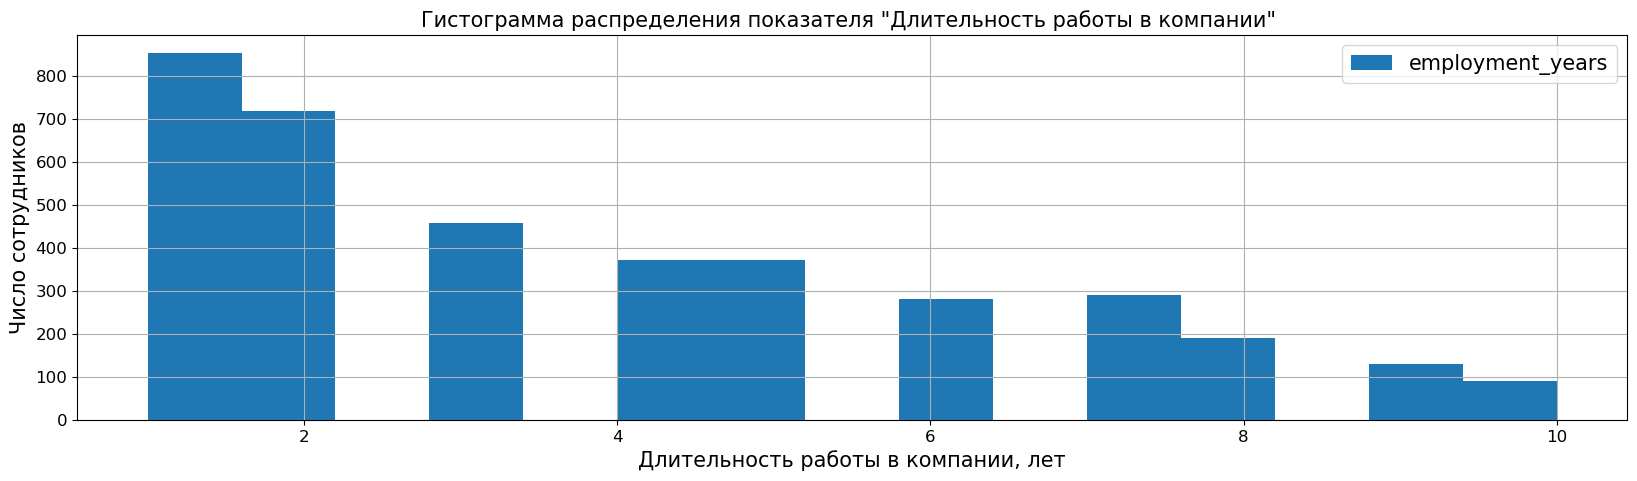

Статистика: count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


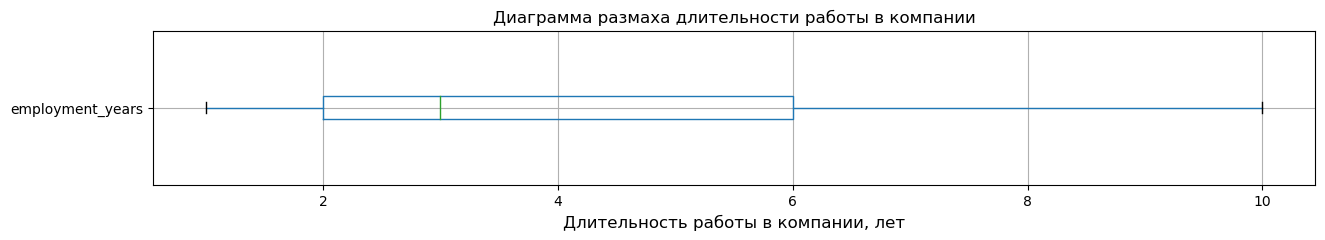

In [22]:
train_job_satisfaction['employment_years'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Длительность работы в компании" ', fontsize=15)
plt.xlabel('Длительность работы в компании, лет', fontsize = 15)
plt.ylabel('Число сотрудников', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = train_job_satisfaction[['employment_years']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха длительности работы в компании')
ax.set_xlabel('Длительность работы в компании, лет', fontsize = 12)

;

print('Статистика:', train_job_satisfaction['employment_years'].describe())

Средний срок работы в компании - 3 года. Больше всего сотрудников работают 1-2 года, но есть люди, работающие в компании по 4-5, 6-8 лет и меньше всего "долгожителе1", работающих по 9-10 лет. Обычное распределение сроков работы в компании.

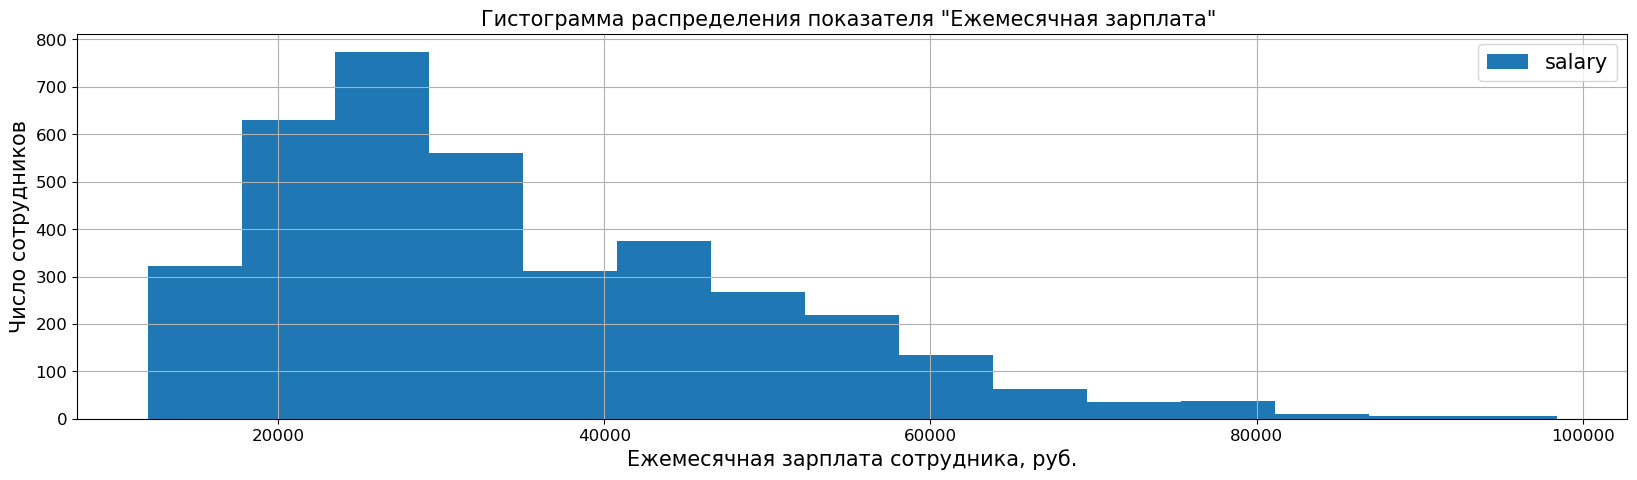

Статистика: count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64


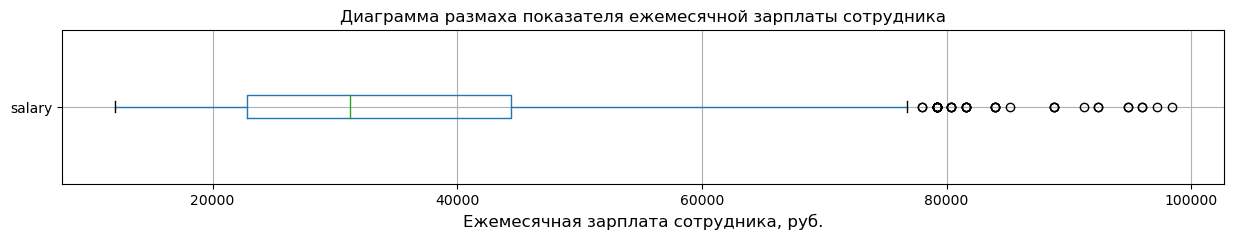

In [23]:
train_job_satisfaction['salary'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Ежемесячная зарплата" ', fontsize=15)
plt.xlabel('Ежемесячная зарплата сотрудника, руб.', fontsize = 15)
plt.ylabel('Число сотрудников', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = train_job_satisfaction[['salary']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха показателя ежемесячной зарплаты сотрудника')
ax.set_xlabel('Ежемесячная зарплата сотрудника, руб.', fontsize = 12)

;

print('Статистика:', train_job_satisfaction['salary'].describe())

Средняя зарпалата сотрудрников - 30 тыс.руб., второй по величине пик зарплат  - около 45 тыс.руб., по логике это группа сотрудников среднего звена. И выше 70 тыс.руб. - это "выбросы", зарплаты сотрудников высшего звена, которых всегда ощутимо меньше остальных, поэтому нельзя назвать это аномалиями.

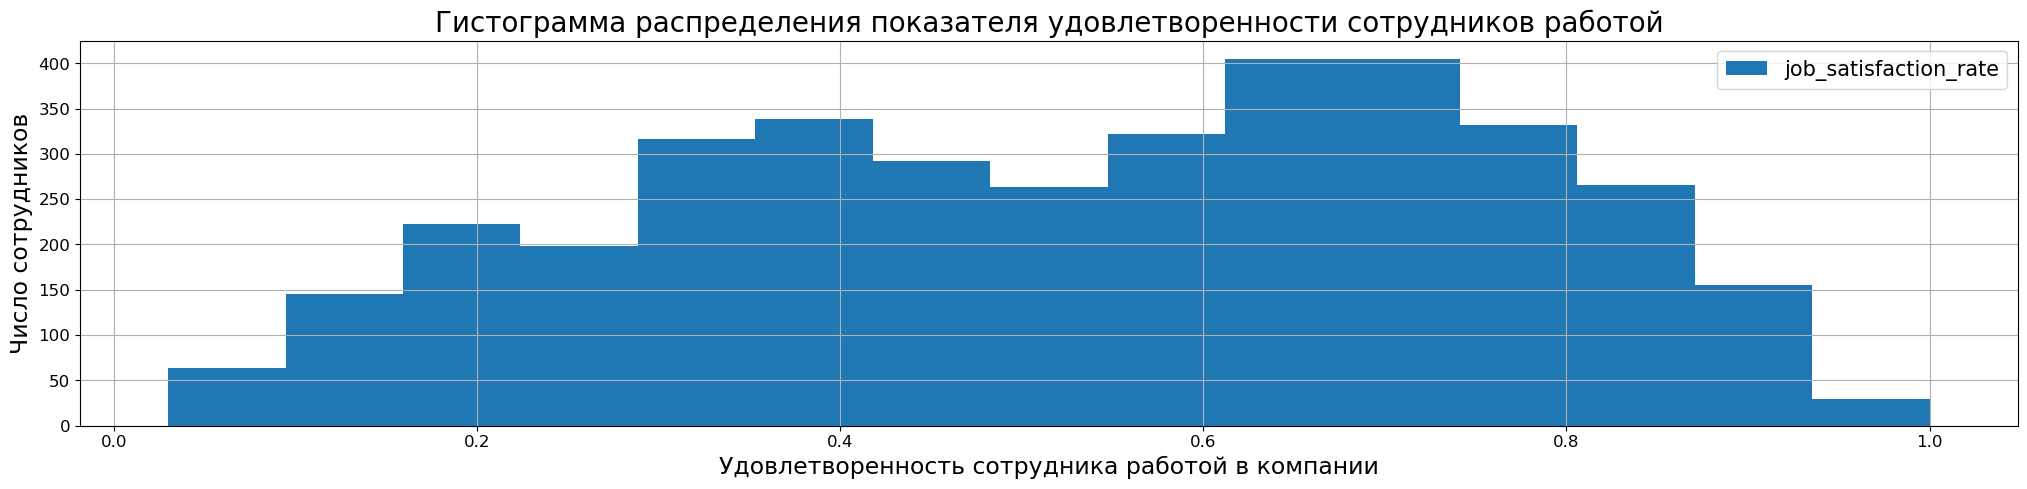

Статистика: count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


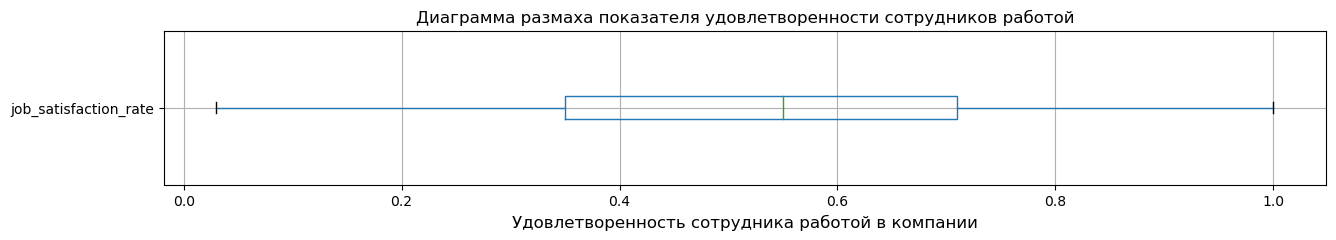

In [26]:
train_job_satisfaction['job_satisfaction_rate'].plot(kind = 'hist', bins = 15, figsize = (25, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя удовлетворенности сотрудников работой', fontsize=20)
plt.xlabel('Удовлетворенность сотрудника работой в компании', fontsize = 17)
plt.ylabel('Число сотрудников', fontsize = 17)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = train_job_satisfaction[['job_satisfaction_rate']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха показателя удовлетворенности сотрудников работой')
ax.set_xlabel('Удовлетворенность сотрудника работой в компании', fontsize = 12)

;

print('Статистика:', train_job_satisfaction['job_satisfaction_rate'].describe())


На гистограмме распределения признака удовлетворенности работой в компании 2 пика: 40% (около 350 сотрудников) и 70% (около 450 сотрудников), среднее медианное значение - 56%.

Переходим к анализу категориальных признаков. Построим столбчатые диаграммы для показателей:
- dept;
- level;
- workload;
- last_year_promo;
- last_year_violations;
- supervisor_evaluation;
- job_satisfaction_rate.

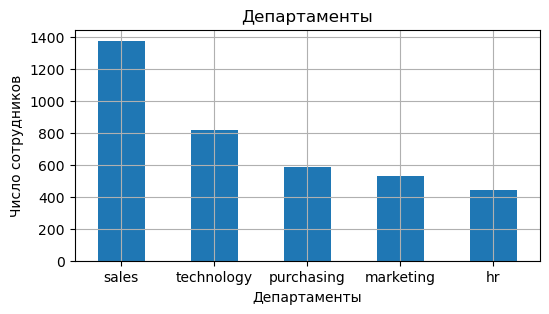

In [28]:
train_job_satisfaction['dept'].value_counts().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Департаменты',\
                                                             xlabel='Департаменты', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

37,8% сотрудников работают в отделе продаж, остальные почти равномерно распределены между другими отделами.

In [29]:
train_job_satisfaction['dept'].value_counts()

dept
sales         1374
technology     818
purchasing     586
marketing      531
hr             440
Name: count, dtype: int64

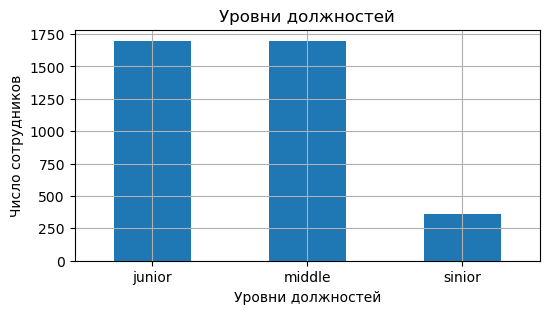

In [31]:
train_job_satisfaction['level'].value_counts().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Уровни должностей',\
                                                             xlabel='Уровни должностей', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [32]:
train_job_satisfaction['level'].value_counts()

level
junior    1699
middle    1695
sinior     357
Name: count, dtype: int64

Пости половина сотрудников компании имеют уровень junior, чуть меньше - уровень middle и 9% - уровень sinior.

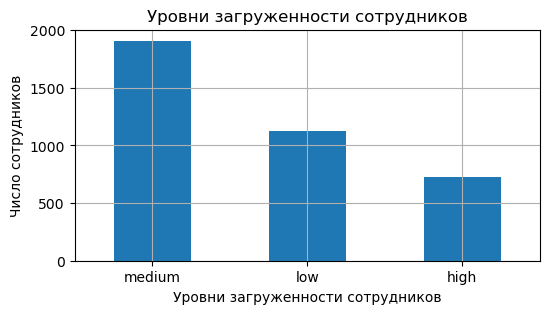

In [34]:
train_job_satisfaction['workload'].value_counts().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Уровни загруженности сотрудников',\
                                                             xlabel='Уровни загруженности сотрудников', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [35]:
train_job_satisfaction['workload'].value_counts()

workload
medium    1908
low       1125
high       722
Name: count, dtype: int64

Половина сотрудников имеют средний уровень загрузки, 30% - низкий и 20% - высокий.

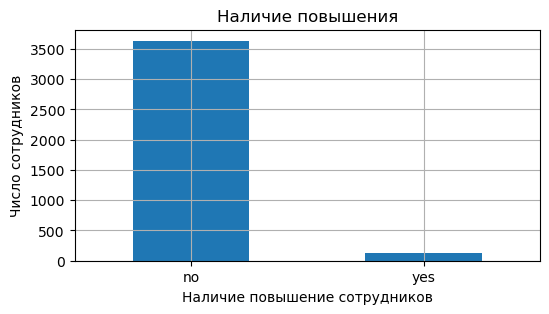

In [37]:
train_job_satisfaction['last_year_promo'].value_counts().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Наличие повышения',\
                                                             xlabel='Наличие повышение сотрудников', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [38]:
train_job_satisfaction['last_year_promo'].value_counts()

last_year_promo
no     3635
yes     120
Name: count, dtype: int64

Только 3% сотрудников получили повышение за последний год. Такое низкое число повышений может негативно влиять на мотивацию и удовлетворенность сотрудников работой.

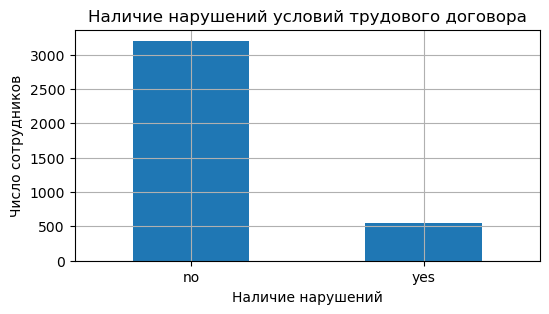

In [40]:
train_job_satisfaction['last_year_violations'].value_counts().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Наличие нарушений условий трудового договора',\
                                                             xlabel='Наличие нарушений', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [41]:
train_job_satisfaction['last_year_violations'].value_counts()

last_year_violations
no     3202
yes     553
Name: count, dtype: int64

14% сотрудников нарушали условия трудового договора за последний год.

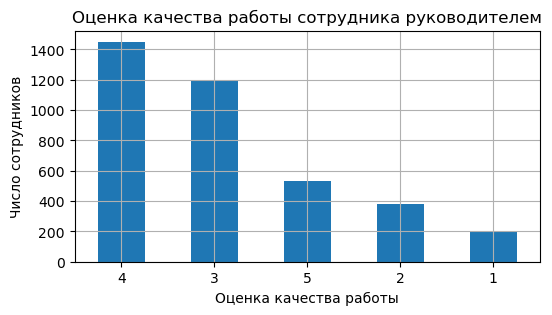

In [43]:
train_job_satisfaction['supervisor_evaluation'].value_counts().plot(kind='bar', figsize = (6, 3),\
                                                             title = 'Оценка качества работы сотрудника руководителем',\
                                                             xlabel='Оценка качества работы', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [44]:
train_job_satisfaction['supervisor_evaluation'].describe()

count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

***Вывод по анализу данных:***

Средняя ззрплата сотрудников  - 30 тыс.руб., что объяснимо тем, что больше половины людей имеют уровень должности junior. Средний срок работы в компании - 3 года, бОльшая часть сотрудников работают в компании по 1-2 года. 37,8% людей работают в отделе продаж, половина сотрудников имеет среднй уровень загрузки. По всем данным никаких аномалий или особенностей не выявлено.

Единственный признак, вызывющий настороженность - очень небольшой процент повышений за последний год (3% сотрудников получили повышение), из чего можно сделать вывод, что это может плохо сказываться на мотивации и удовлетворенности работой.

**Корреляционный анализ**

In [45]:
display(train_job_satisfaction.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [46]:
train_job_satisfaction_phik = train_job_satisfaction[['job_satisfaction_rate', 'dept', 'level', 'workload',
                                    'employment_years', 'last_year_promo', 'last_year_violations',\
                                    'supervisor_evaluation', 'salary']]

corr_matrix_train_job_satisf = train_job_satisfaction_phik.phik_matrix(interval_cols = [
                                   'salary', 'job_satisfaction_rate']
                                    ) 
display(corr_matrix_train_job_satisf)

,job_satisfaction_rate,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
job_satisfaction_rate,1.000000,0.074739,0.077260,0.043958,0.319331,0.191464,0.566993,0.762964,0.149599
dept,0.074739,1.000000,0.000000,0.018079,0.025931,0.000000,0.000000,0.100579,0.270239
level,0.077260,0.000000,1.000000,0.404459,0.675467,0.100352,0.000000,0.000000,0.714411
workload,0.043958,0.018079,0.404459,1.000000,0.165879,0.057938,0.000000,0.037565,0.785277
employment_years,0.319331,0.025931,0.675467,0.165879,1.000000,0.180832,0.043766,0.000000,0.469992
last_year_promo,0.191464,0.000000,0.100352,0.057938,0.180832,1.000000,0.011274,0.016247,0.211173
last_year_violations,0.566993,0.000000,0.000000,0.000000,0.043766,0.011274,1.000000,0.183221,0.000000
supervisor_evaluation,0.762964,0.100579,0.000000,0.037565,0.000000,0.016247,0.183221,1.000000,0.000000
salary,0.149599,0.270239,0.714411,0.785277,0.469992,0.211173,0.000000,0.000000,1.000000


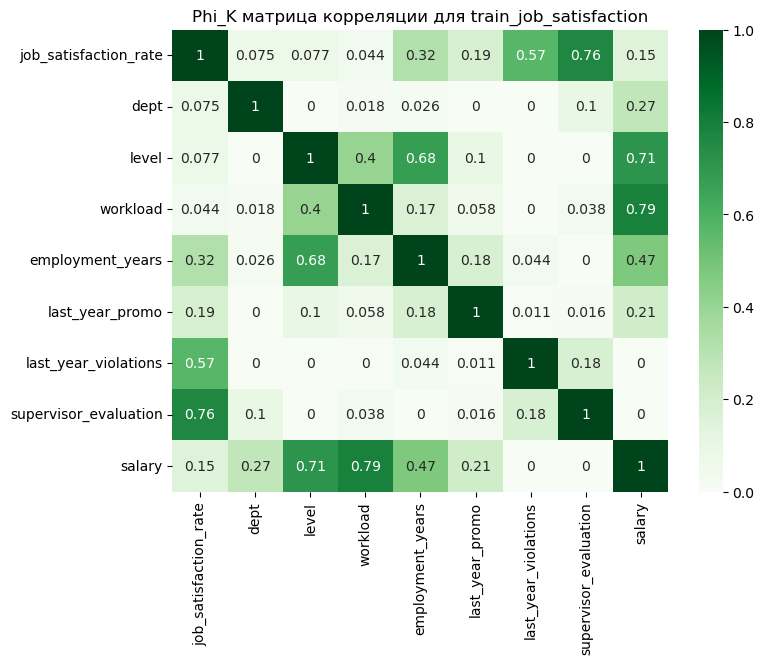

In [48]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix_train_job_satisf, annot=True, cmap='Greens')
plt.title('Phi_K матрица корреляции для train_job_satisfaction')
plt.show()

ОТносительно высокая корреляцию видим у целевого признака с фактором оценки работы сотрудника руководством - 76%, ощутимая корреляция с числом нарушений трудового договора - 56%, т е сотрудники, нарушающие трудовой договор, закономерно имеют бОльшие щшансы на увольнение. 

Странно, что корреляция с уровнем зарплаты не высокая.

**Шаг 4. Подготовка данных**

Разделим данные на тренировочную и тестовую выборки.

In [49]:
X_train = train_job_satisfaction.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction['job_satisfaction_rate']

X_test = satisf_test_features
y_test = satisf_test_target['job_satisfaction_rate']

Перечни категориальных и количественных столбцов, списки для OneHotEncoder и OrdinalEncoder мы определили на прошлом шаге. 

In [50]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload', 'supervisor_evaluation']

num_columns = ['employment_years', 'salary']

Добавляем **OHE-кодирование** в Пайплайн

**1)** Если в данных есть пропуски, заполним их самым часто встречающимся значением с помощью SimpleImputer. Назовём этот шаг simpleImputer_ohe. 

**2)** Кодируем данные с помощью OneHotEncoder. Назовём это шаг ohe.

**3)** Объединим шаги в пайплайн и назовём его ohe_pipe.

In [51]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

Добавляем **Ordinal-кодирование** в пайплайн.

**1)** simpleImputer_before_ord: Заполним пропуски самым часто встречающимся значением с помощью SimpleImputer. Пропуски есть только в столбце 'level': по уровню зарплаты (ниже среднего) в этих строках с пропусками можно сделать вывод, что эти сотрудники имеют должность junior, которая как раз является самым распространенным значением признака, поэтому в данном случае заполнение most_frequent будет корректно.

**2)** ord: Проводим Ordinal-кодирование с помощью OrdinalEncoder.

**3)** simpleImputer_after_ord: Заполним пропуски, которые появляются после Ordinal-кодирования.

**4)** ord_pipe: Объединим все действия в пайплайн.

In [52]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'sinior'],
                             ['low', 'medium', 'high'],
                             [1, 2, 3, 4, 5]
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Применим инструмент ColumnTransformer для объединения всех операций по подготовке данных.

In [53]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

***Выводы по подготовке данных:***

***1)*** Количественные признаки employment_years, salary  нужно отмасштабировать одним из скейлеров (Standard, Robust или MinMax) - какой из скейлеров использовать, определим при выборе лучшей модели. Можно предположить, что для признака salary больше подойдет RobustScaler, т к при масштабировании он учитывает выбросы и сохраняет структуру распределения данных.

***2)*** Признак 'dept' (отдел) нужно кодировать OneHotEncoder - это не ранговый признак. OneHotEncoder использвуем для кодирования признака 'last_year_promo' (повышение) и 'last_year_violations' (наличие нарушений трудового договора), это бинарные признаки.

***3)*** Признак 'level' кодируем с помощью OrdinalEncoder, т к значения признака можно ранжировать в порядке увеличения значимости: 'junior', 'middle', 'sinior'.

Признак 'workload' (загруженность) тоже кодируем с помощью OrdinalEncoder, т к это ранговый признак,значения которого увеличиваются: 'low', 'medium', 'high'.

Признак 'supervisor_evaluation' (оценка качества работы сотрудника) кодируем с помощью OrdinalEncoder, т к значения признака можно ранжировать в порядке увеличения значимости: 1, 2, 3, 4, 5.

***4)*** Целевой признак кодировать и масштабировать не нужно, т к это количественный признак с непрерывным диапазоном значений [0, 1]. 


Пайплайн подготовки данных создан. Приступаем к

**Шаг 5. Обучение моделей**

Будем использовать модель DecisionTreeRegressor. Итоговый пайплайн назовём pipe_final. Он включает шаги:

Подготовка данных — шаг preprocessor. Инициализация модели DecisionTreeClassifier — шаг models.

In [54]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
) 

Зададим метод масштабирования как гиперпараметр, чтобы перебирались методы StandardScaler(), RobustScaler() и MinMaxScaler(). Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV.

В словаре укажем, какие варианты масштабирования собираемся перебрать: StandardScaler(), RobustScaler(), MinMaxScaler() и вариант без масштабирования.

Зададим в качестве гиперпараметра модели, которые хотим использовать: DecisionTreeRegressor(), LinearRegression().

In [55]:
param = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(criterion = 'friedman_mse', random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15), 
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
     # словарь для модели LogisticRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

Для оценки качества работы модели будем использовать метрику SMAPE («симметричное среднее абсолютное процентное отклонение»). Зададим функцию для расчета этой метрики.

In [56]:
def smape(y_test, y_pred):
    numerator = np.abs(y_pred - y_test)
    denominator = (np.abs(y_test)+np.abs(y_pred))/2
    smape_value = np.mean(numerator/denominator)*100
    return smape_value
    
smape_metrics = make_scorer(smape, greater_is_better = False)

Запустим автоматический подбор с помощью RandomizedSearchCV:

In [57]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param, 
    scoring = smape_metrics,
    error_score= 'raise',
    n_iter=50,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search.fit(X_train, y_train) 

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline...
                                         'models__min_samples_leaf': range(2, 15),
                                         'models__min_samples_split': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [58]:
print('Метрика smape для лучшей модели:\n', randomized_search.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика smape для лучшей модели:
 -15.720216885825687
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleIm

Проверим метрику smape на тестовой выборке:

In [59]:
y_test_pred = randomized_search.predict(X_test)
print('Метрика smape на тестовой выборке:', smape(y_test, y_test_pred))

Метрика smape на тестовой выборке: 14.088078338458338


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Вывод:**

Мы обучили 2 модели: дерево решений и линейную регрессию, в качестве гипарпараметров использовали методы масштабирования, Для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели мы создали метрику SMAPE («симметричное среднее абсолютное процентное отклонение»)
 По итогам подбора лучшей моделью стала модель DecisionTreeRegressor со следующими параметрами: criterion='friedman_mse', max_depth=14, max_features=9, min_samples_leaf=43, min_samples_split=9.
 Метрика SMAPE на тестовой выборке - 14,09%.
                                       


## Задача 2: предсказание увольнения сотрудника из компании

**Шаг 1. Загрузка данных**

Загрузим тренировочную выборку с данными для прогноза увольнения сотрудников из копмании.

In [61]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')

In [62]:
display(train_quit.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [63]:
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [64]:
display(test_target_quit.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Проверим порядок строк в файлах тестовой выборке входных признаков (satisf_test_features) и целевым признаком тестовой выборки (test_target_quit):

In [65]:
display(satisf_test_features.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


In [66]:
display(test_target_quit.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


Чтобы привести строки в тестовой выборке и целевым признаком тестовой выборки к одинаковому порядку, отсортируем строки в таблице с целевым признаком тестовой выборки.

In [67]:
test_target_quit = test_target_quit.sort_values(by = 'id')

In [68]:
display(test_target_quit.head())

,id,quit
1566,100298,no
491,100480,no
802,100503,no
725,100610,no
319,100692,no


Переместим значения id в индекс:

In [69]:
train_quit = train_quit.set_index('id')
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


In [70]:
test_target_quit = test_target_quit.set_index('id')
display(test_target_quit.head())

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


Загрузили таблицы, привели строки в таблицах со входными и целевым признаками к одинаковому порядку, отсортировав по id.

**Шаг 2. Предобработка данных**

Проверим данные на наличие пропусков.

In [71]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


In [72]:
test_target_quit.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100298 to 999029
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


Пропусков нет.

Посмотрим уникальные значения столбцов в тренировочной выборке, проверим наличие неявных дубликатов.

In [73]:
train_quit['dept'].unique()

array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
      dtype=object)

In [74]:
train_quit['level'].unique()

array(['middle', 'junior', 'sinior'], dtype=object)

In [75]:
train_quit['workload'].unique()

array(['high', 'medium', 'low'], dtype=object)

In [76]:
train_quit['last_year_promo'].unique()

array(['no', 'yes'], dtype=object)

In [77]:
train_quit['last_year_violations'].unique()

array(['no', 'yes'], dtype=object)

In [78]:
train_quit['supervisor_evaluation'].unique()

array([4, 1, 3, 5, 2])

Ошибок в названиях значений нет.

Проверим на полные дубликаты:

In [74]:
train_quit.duplicated().sum()

1413

После перемещения id в индекс получили 1413 полных дубликатов, посмотрим на эти строки.

In [75]:
display(train_quit[train_quit.duplicated()])

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
873412,technology,junior,medium,2,no,no,4,31200,no
749683,sales,middle,low,8,no,no,4,19200,no
689526,marketing,middle,low,6,no,no,3,30000,no
786443,purchasing,middle,low,6,no,no,4,19200,no
362060,sales,junior,low,1,no,no,4,12000,yes
...,...,...,...,...,...,...,...,...,...
632886,sales,junior,low,3,no,no,4,12000,no
387733,marketing,middle,medium,5,no,no,3,44400,no
588809,sales,junior,medium,4,no,no,3,26400,no


Полные дуликаты, получившиеся после перемещения id в ирндекс, удаляем, т к полное совпадение всех признаков у разных строк может негативно с казаться на качестве обученной на такой выборке модели.

In [76]:
train_quit = train_quit.drop_duplicates()
train_quit.duplicated().sum()

0

**Шаг 3. Исследовательский анализ данных**

Начнем с анализа количественных показателей в файле train_quit. Построим гистограммы и диаграммы размаха для количественных показателей: employment_years, salary.

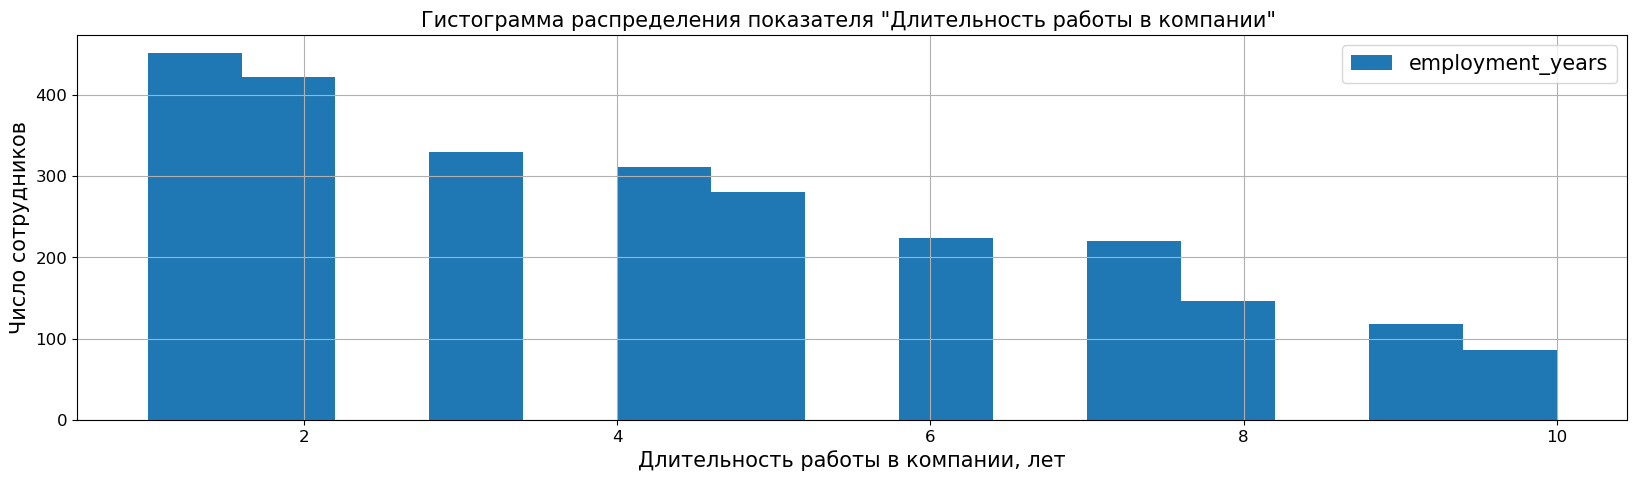

Статистика: count    2587.000000
mean        4.213375
std         2.601105
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64


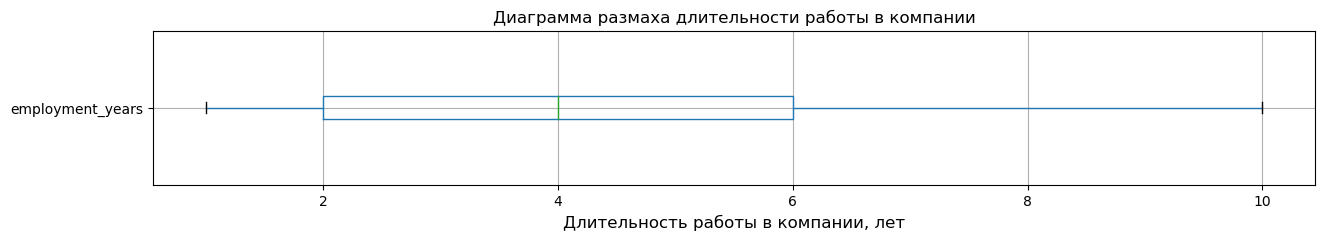

In [77]:
train_quit['employment_years'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Длительность работы в компании" ', fontsize=15)
plt.xlabel('Длительность работы в компании, лет', fontsize = 15)
plt.ylabel('Число сотрудников', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = train_quit[['employment_years']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха длительности работы в компании')
ax.set_xlabel('Длительность работы в компании, лет', fontsize = 12)

;

print('Статистика:', train_quit['employment_years'].describe())

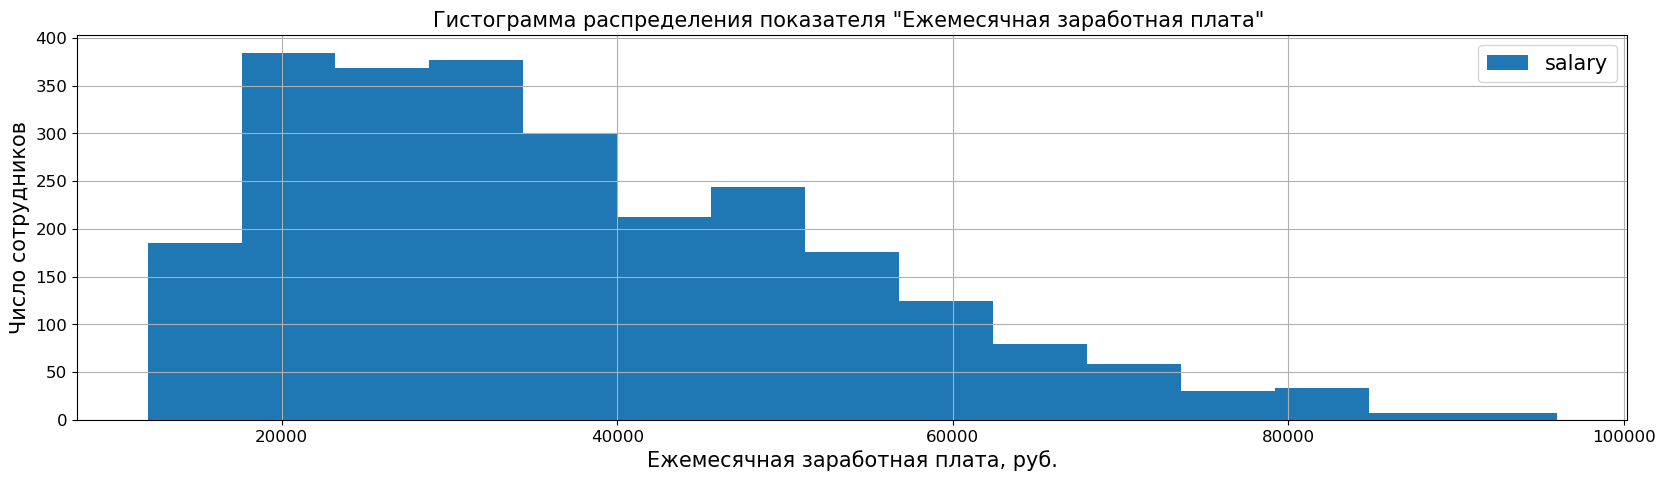

Статистика: count     2587.000000
mean     37107.692308
std      16267.354906
min      12000.000000
25%      24000.000000
50%      33600.000000
75%      46800.000000
max      96000.000000
Name: salary, dtype: float64


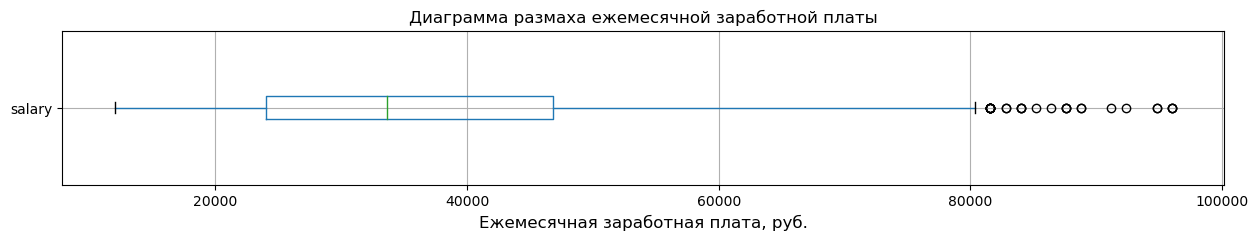

In [78]:
train_quit['salary'].plot(kind = 'hist', bins = 15, figsize = (20, 5), grid = True, legend = True)
plt.title('Гистограмма распределения показателя "Ежемесячная заработная плата" ', fontsize=15)
plt.xlabel('Ежемесячная заработная плата, руб.', fontsize = 15)
plt.ylabel('Число сотрудников', fontsize = 15)
plt.legend(fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

fig, ax = plt.subplots(figsize = (15,2))
ax = train_quit[['salary']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха ежемесячной заработной платы')
ax.set_xlabel('Ежемесячная заработная плата, руб.', fontsize = 12)

;

print('Статистика:', train_quit['salary'].describe())

Переходим к анализу категориальных признаков. Построим столбчатые диаграммы для показателей:

- dept;
- level;
- workload;
- last_year_promo;
- last_year_violations;
- supervisor_evaluation;
- quit (целевой).

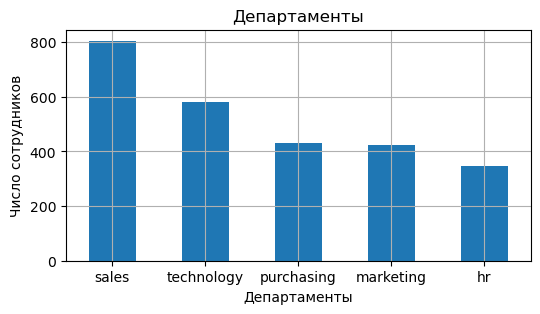

In [80]:
train_quit['dept'].value_counts().plot(kind='bar', figsize = (6, 3), \
                                                             title = 'Департаменты',\
                                                             xlabel='Департаменты', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [81]:
train_quit['dept'].value_counts()

dept
sales         805
technology    581
purchasing    430
marketing     423
hr            348
Name: count, dtype: int64

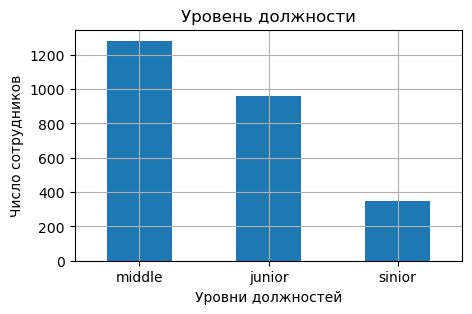

In [86]:
train_quit['level'].value_counts().plot(kind='bar', figsize = (5, 3),\
                                                             title = 'Уровень должности',\
                                                             xlabel='Уровни должностей', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [83]:
train_quit['level'].value_counts()

level
middle    1282
junior     958
sinior     347
Name: count, dtype: int64

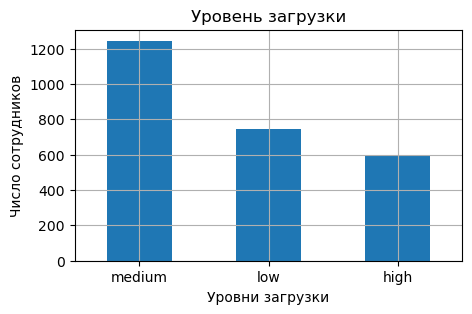

In [85]:
train_quit['workload'].value_counts().plot(kind='bar', figsize = (5, 3),\
                                                             title = 'Уровень загрузки',\
                                                             xlabel='Уровни загрузки', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [87]:
train_quit['workload'].value_counts()

workload
medium    1244
low        746
high       597
Name: count, dtype: int64

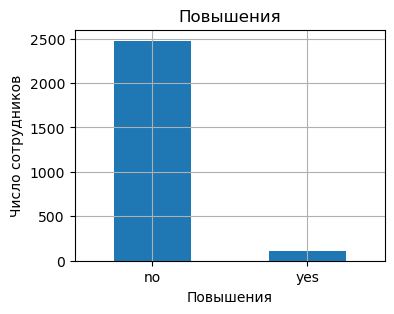

In [88]:
train_quit['last_year_promo'].value_counts().plot(kind='bar', figsize = (4, 3),\
                                                             title = 'Повышения',\
                                                             xlabel='Повышения', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [89]:
train_quit['last_year_promo'].value_counts()

last_year_promo
no     2476
yes     111
Name: count, dtype: int64

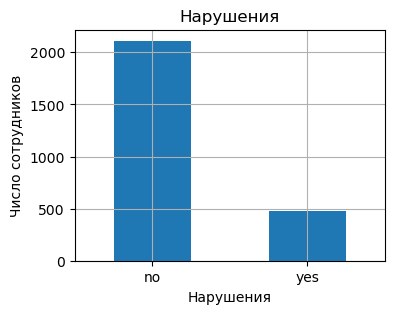

In [90]:
train_quit['last_year_violations'].value_counts().plot(kind='bar', figsize = (4, 3),\
                                                             title = 'Нарушения',\
                                                             xlabel='Нарушения', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [91]:
train_quit['last_year_violations'].value_counts()

last_year_violations
no     2111
yes     476
Name: count, dtype: int64

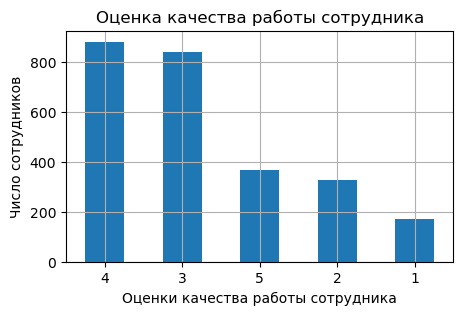

In [92]:
train_quit['supervisor_evaluation'].value_counts().plot(kind='bar', figsize = (5, 3),\
                                                             title = 'Оценка качества работы сотрудника',\
                                                             xlabel='Оценки качества работы сотрудника', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [93]:
train_quit['supervisor_evaluation'].value_counts()

supervisor_evaluation
4    882
3    839
5    369
2    326
1    171
Name: count, dtype: int64

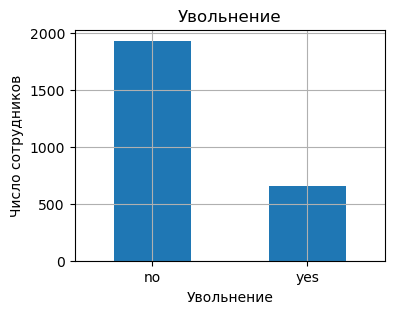

In [94]:
train_quit['quit'].value_counts().plot(kind='bar', figsize = (4, 3),\
                                                             title = 'Увольнение',\
                                                             xlabel='Увольнение', \
                                                             ylabel='Число сотрудников', grid = True, rot=0);

In [95]:
train_quit['quit'].value_counts()

quit
no     1932
yes     655
Name: count, dtype: int64

Распределения значений признаков очень похоже с распределением признаков в первой задаче.

Для построения "портрета уволившегося сотрудника" разделим таблицу train_quit на две части: в одной будут уволившиеся сотрудники, в другой - оставшиеся.


In [96]:
train_quit_stable = train_quit.loc[train_quit['quit'] == 'no']

In [97]:
display(train_quit_stable.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
910140,marketing,junior,medium,2,no,no,5,25200,no
417070,technology,middle,medium,8,no,no,2,44400,no


In [98]:
train_quit_retired = train_quit.loc[train_quit['quit'] == 'yes']

In [99]:
display(train_quit_retired.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
257132,sales,junior,medium,2,no,yes,3,24000,yes
699916,sales,junior,low,1,no,yes,3,18000,yes
613206,technology,middle,medium,2,no,no,3,45600,yes
468145,technology,junior,medium,2,no,no,3,30000,yes
982346,marketing,junior,medium,3,no,no,3,30000,yes


Сделаем графики, на которых будут отображены по 2 гистограммы распределения признаков из обеих таблиц. Проанализируем гистограммы распределения количественных признаков: salary, employment_years.


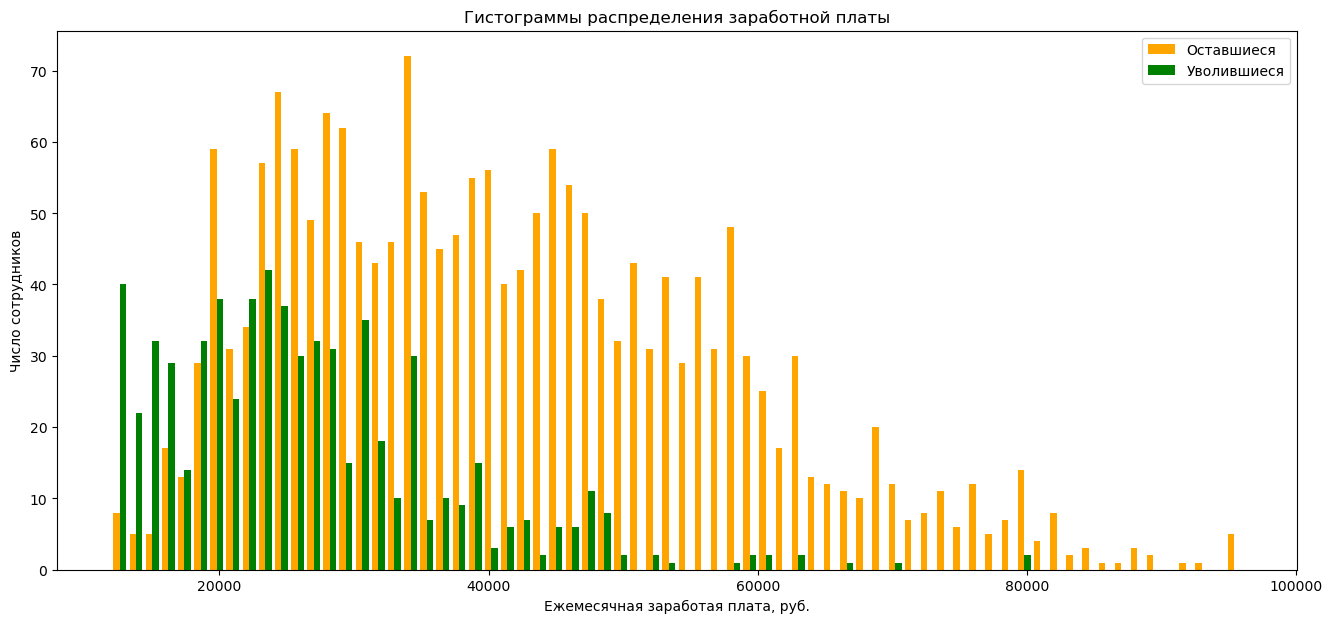

In [100]:
x1 = list(train_quit_stable['salary'])
x2 = list(train_quit_retired['salary'])

colors = ['orange', 'green']
names = ['Оставшиеся', 'Уволившиеся']

k = plt.figure()
k.set_figwidth(16)
k.set_figheight(7)
plt.hist([x1, x2], bins = 70,
         color = colors, label=names)

plt.legend()
plt.title('Гистограммы распределения заработной платы')
plt.xlabel('Ежемесячная заработая плата, руб.')
plt.ylabel('Число сотрудников')
plt.show();

Построим гистораммы плотности, чтобы добиться наибольшей сопоставимости групп, установим параметр coomon_norm = False, чтобы нормализовать каждую гистотграмму отдельно.

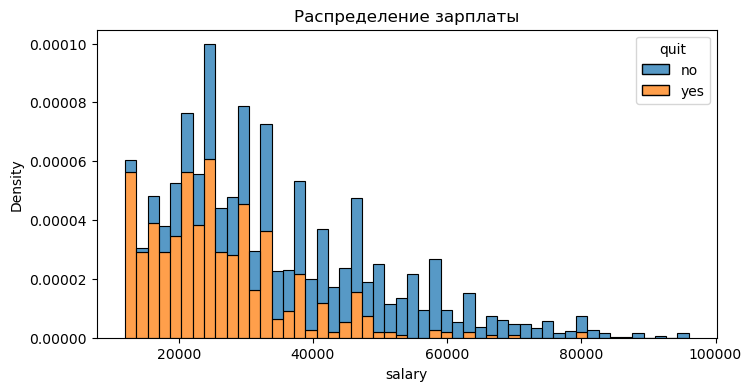

In [102]:
plt.figure(figsize=(8, 4))
sns.histplot(data=train_quit, 
             x="salary", 
             bins=50, 
             hue="quit", 
             multiple="stack",
             stat='density', 
             common_norm=False).set(title='Распределение зарплаты');

Диаграммы размаха зарплат уволившихся и оставшихся сотрудников.

Статистика: count     1932.000000
mean     40952.173913
std      16085.739667
min      12000.000000
25%      27600.000000
50%      39000.000000
75%      51600.000000
max      96000.000000
Name: salary, dtype: float64


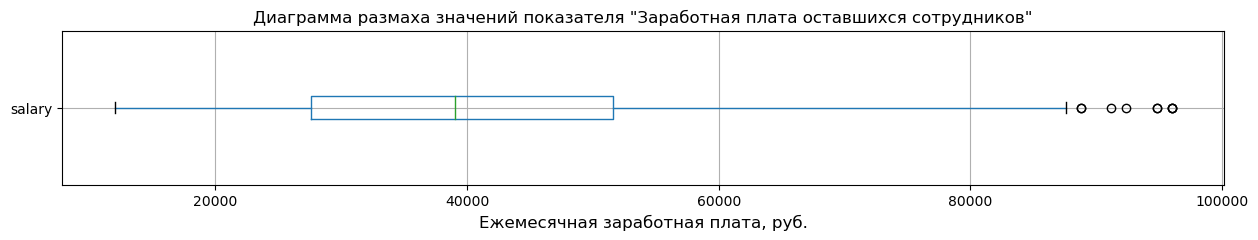

In [103]:
fig, ax = plt.subplots(figsize = (15,2))
ax = train_quit_stable[['salary']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Заработная плата оставшихся сотрудников"')
ax.set_xlabel('Ежемесячная заработная плата, руб.', fontsize = 12)

;

print('Статистика:', train_quit_stable['salary'].describe())

Статистика: count      655.000000
mean     25767.938931
std      10484.828614
min      12000.000000
25%      18000.000000
50%      24000.000000
75%      30600.000000
max      79200.000000
Name: salary, dtype: float64


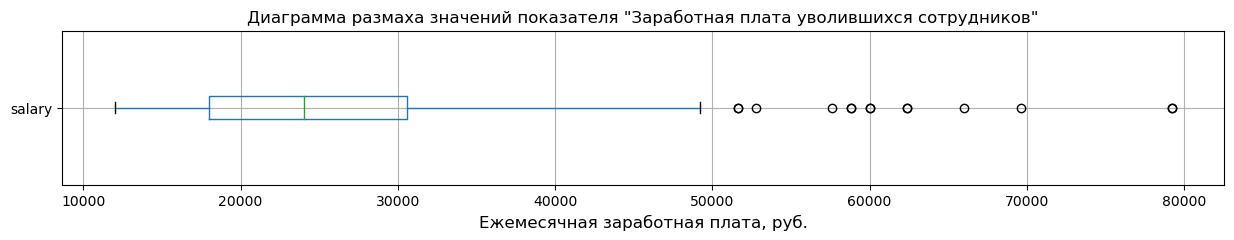

In [104]:
fig, ax = plt.subplots(figsize = (15,2))
ax = train_quit_retired[['salary']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений показателя "Заработная плата уволившихся сотрудников"')
ax.set_xlabel('Ежемесячная заработная плата, руб.', fontsize = 12)

;

print('Статистика:', train_quit_retired['salary'].describe())

Глядя на гистограммы и диаграммы размаха признака "Заработная плата сотрудников" можно сделать выводы:

**1)** Больше всего увольнений у сотрудников с зарплатой около 10 тыс. руб. (самый высокий пик на гистограмме). Скорее всего, это персонал, нанятый на полставки или меньше для выполнения сопутствующих работ вроде курьерской доставки, уборки, обсуживания помещений. Средняя зарплата уволившихся сотрудников - 23 тыс.руб, три четверти уволившихся сотрудников имели зарплаты до 27,6 тым.руб. Есть единичные случаи увольнения сотрудников со средними зарплатами.

**2)** Средняя зп оставшихся сотрудников - 35 тыс.руб., три четверти уволившихся сотрудников имели зарплаты до 48 тыс.руб. Сорудники с зарплатой более 80 тыс. не увольняются.


Построим гистограммы и диаграммы размаха для показателя "employment_years"

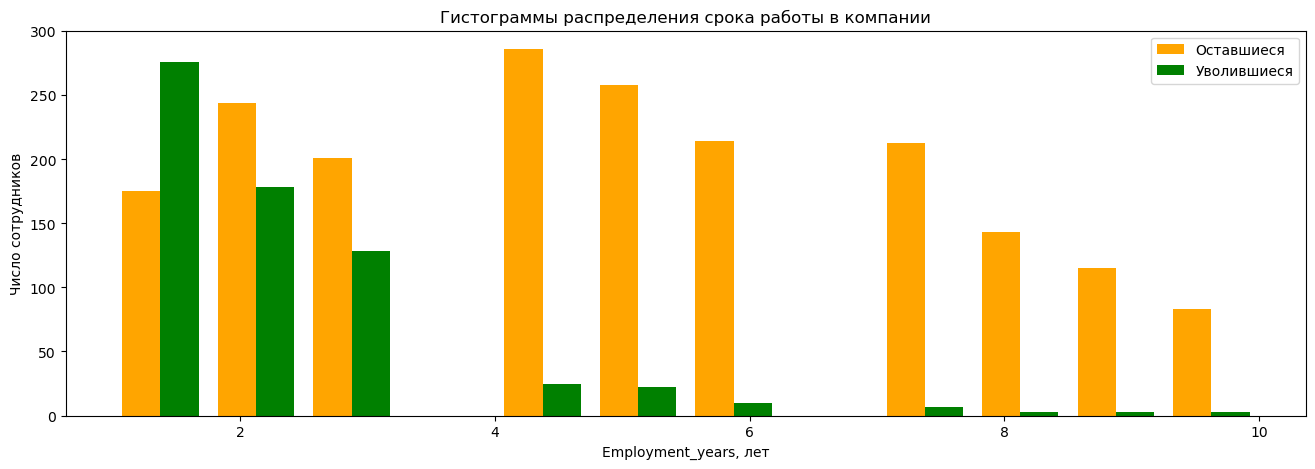

In [110]:
x1 = list(train_quit_stable['employment_years'])
x2 = list(train_quit_retired['employment_years'])

colors = ['orange', 'green']
names = ['Оставшиеся', 'Уволившиеся']

k = plt.figure()
k.set_figwidth(16)
k.set_figheight(5)
plt.hist([x1, x2], bins = 12,
         color = colors, label=names),
plt.legend()
plt.title('Гистограммы распределения срока работы в компании')
plt.xlabel('Employment_years, лет')
plt.ylabel('Число сотрудников')
plt.show();

Диаграммы размаха срока работы в компании оставшихся и уволившихся сотрудников.

Статистика: count    1932.000000
mean        4.908903
std         2.527730
min         1.000000
25%         3.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: employment_years, dtype: float64


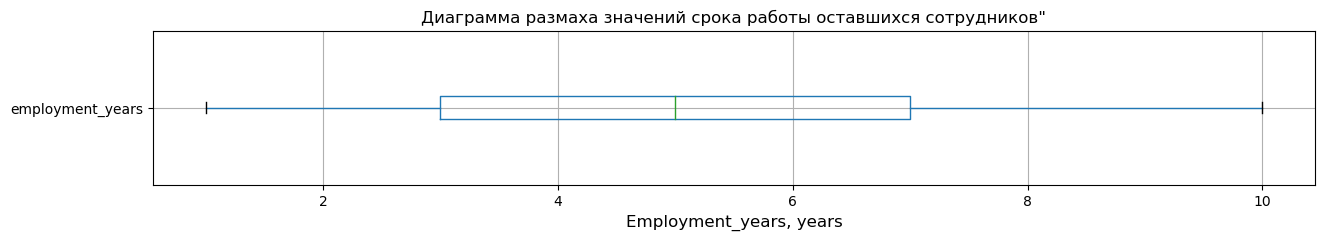

In [111]:
fig, ax = plt.subplots(figsize = (15,2))
ax = train_quit_stable[['employment_years']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений срока работы оставшихся сотрудников"')
ax.set_xlabel('Employment_years, years', fontsize = 12)

;

print('Статистика:', train_quit_stable['employment_years'].describe())

Статистика: count    655.000000
mean       2.161832
std        1.497626
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       10.000000
Name: employment_years, dtype: float64


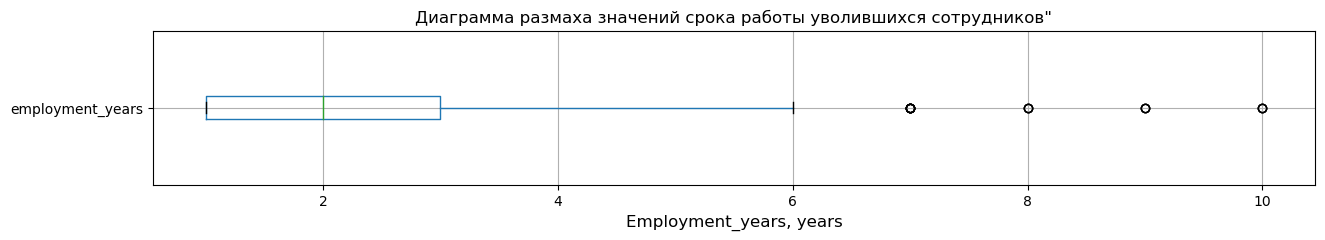

In [112]:
fig, ax = plt.subplots(figsize = (15,2))
ax = train_quit_retired[['employment_years']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений срока работы уволившихся сотрудников"')
ax.set_xlabel('Employment_years, years', fontsize = 12)

;

print('Статистика:', train_quit_retired['employment_years'].describe())

**Вывод** по анализу признака "Срок работы в компании":

Больше всего увольнений  - у сотрудников со сроком работы 1 год, три четверти уволившихся сорудников работали в компании менее 2 лет. Увольнения сотрудников сроком работы более 4 лет единичны.



Построим barplots, где по ОХ будут указаны отделы, по ОУ - число сотрудников. Разными цветами обозначим графики с уволившимися и оставшимися сотрудниками.

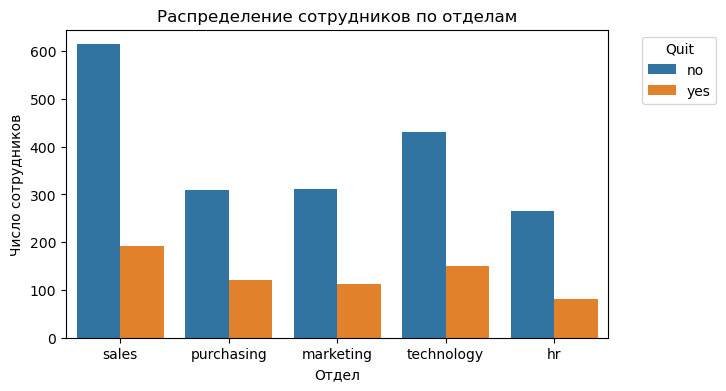

In [194]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'dept', hue = 'quit', data = train_quit)
plt.xlabel('Отдел')
plt.ylabel('Число сотрудников')
plt.title('Распределение сотрудников по отделам')
plt.legend(title='Quit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Построим гистограмму распределения признака доли увольняющихся и остающихся сотрудников, работающих в разных отделах. 

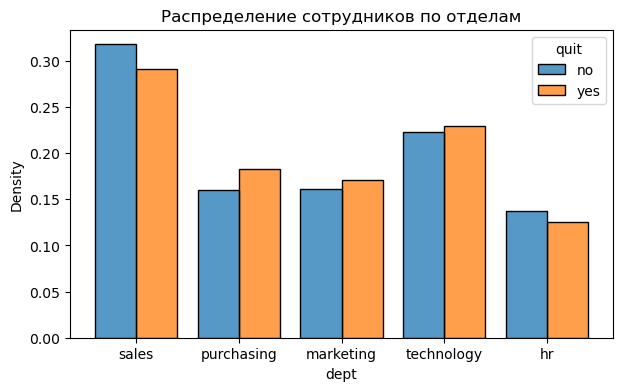

In [116]:
plt.figure(figsize=(7, 4))
sns.histplot(data=train_quit, 
             x="dept",  
             hue="quit", 
             multiple="dodge",
             shrink = .8,
             stat='density', 
             common_norm=False).set(title='Распределение сотрудников по отделам');

Чаще всего увольняются сотрудники из отдела продаж (около 28% увольняющихся  сотрудников), чуть меньше - из отдела 'technology' (23% увольняющихся). Сотрудники отделов закупок, маркетинга увольняются меньше 

In [117]:
display(train_quit_stable['workload'].value_counts())

workload
medium    989
high      488
low       455
Name: count, dtype: int64

In [118]:
display(train_quit_retired['workload'].value_counts())

workload
low       291
medium    255
high      109
Name: count, dtype: int64

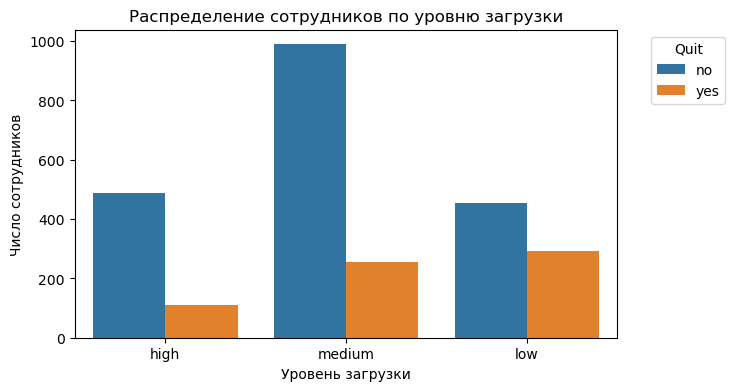

In [195]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'workload', hue = 'quit', data = train_quit)
plt.xlabel('Уровень загрузки')
plt.ylabel('Число сотрудников')
plt.title('Распределение сотрудников по уровню загрузки')
plt.legend(title='Quit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Построим гистограмму распределения признака доли увольняющихся и остающихся сотрудников, имеющих разный уровень загрузки. 

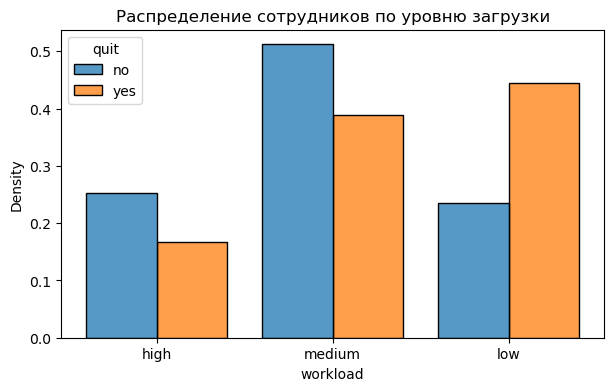

In [196]:
plt.figure(figsize=(7, 4))
sns.histplot(data=train_quit, 
             x="workload",  
             hue="quit", 
             multiple="dodge",
             shrink = .8,
             stat='density', 
             common_norm=False).set(title='Распределение сотрудников по уровню загрузки');

45% увольняющихся сотрудников имели низкий уровень загрузки, 40% увольняющихся сотрудников имели средний уровень загрузки и 15% уволившихся сотрудников имели высокий уровень загрузки.

In [123]:
display(train_quit_stable['last_year_promo'].value_counts())

last_year_promo
no     1822
yes     110
Name: count, dtype: int64

In [124]:
display(train_quit_retired['last_year_promo'].value_counts())

last_year_promo
no     654
yes      1
Name: count, dtype: int64

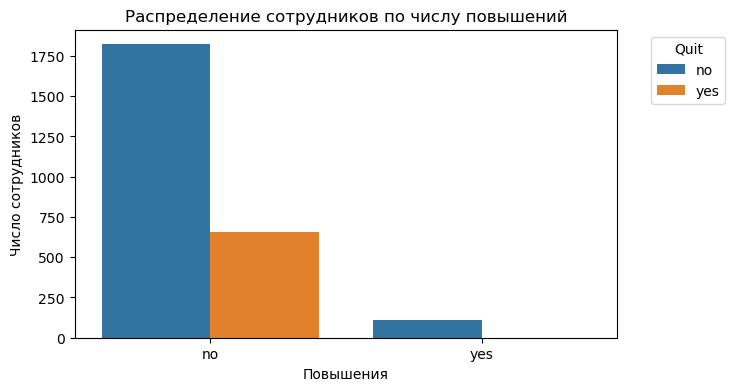

In [197]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'last_year_promo', hue = 'quit', data = train_quit)
plt.xlabel('Повышения')
plt.ylabel('Число сотрудников')
plt.title('Распределение сотрудников по числу повышений')
plt.legend(title='Quit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Построим гистограмму распределения признака доли увольняющихся и остающихся сотрудников, получивших и не получивших повышение. 

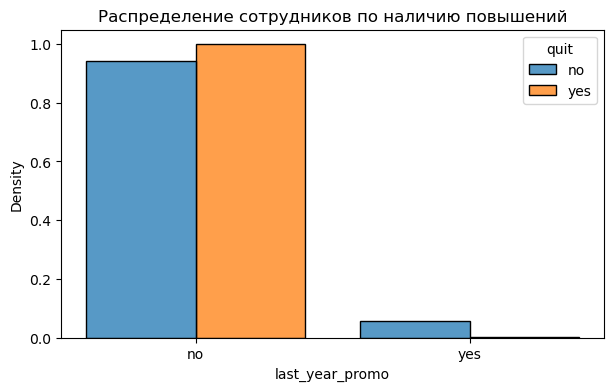

In [198]:
plt.figure(figsize=(7, 4))
sns.histplot(data=train_quit, 
             x="last_year_promo",  
             hue="quit", 
             multiple="dodge",
             shrink = .8,
             stat='density', 
             common_norm=False).set(title='Распределение сотрудников по наличию повышений');

100% уволившихся сотрудников не получили повышения за последний год. Сотрудники, получившие повышение, не увольняются (за весь период уволился только 1 сорудник с повышением).

In [129]:
display(train_quit_stable['last_year_violations'].value_counts())

last_year_violations
no     1636
yes     296
Name: count, dtype: int64

In [130]:
display(train_quit_retired['last_year_violations'].value_counts())

last_year_violations
no     475
yes    180
Name: count, dtype: int64

Построим гистограмму распределения признака доли увольняющихся и остающихся сотрудников, допустивших и не допускавших нарушения трудового договора.

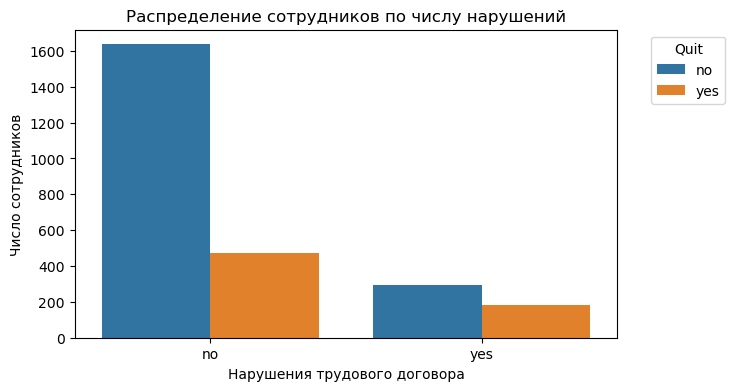

In [199]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'last_year_violations', hue = 'quit', data = train_quit)
plt.xlabel('Нарушения трудового договора')
plt.ylabel('Число сотрудников')
plt.title('Распределение сотрудников по числу нарушений')
plt.legend(title='Quit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Построим гистограмму распределения признака доли увольняющихся и остающихся сотрудников, допустивших и не допускавших нарушения трудового договора.

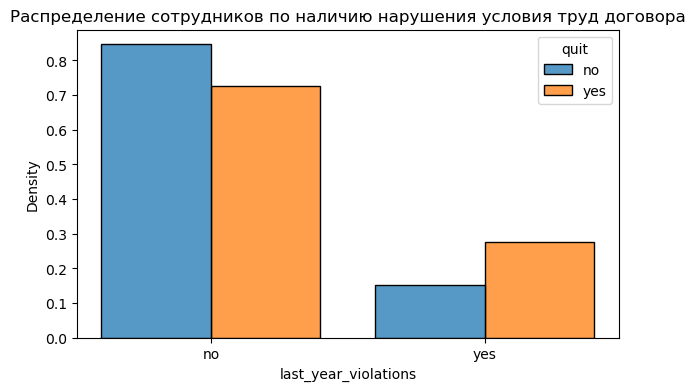

In [200]:
plt.figure(figsize=(7, 4))
sns.histplot(data=train_quit, 
             x="last_year_violations",  
             hue="quit", 
             multiple="dodge",
             shrink = .8,
             stat='density', 
             common_norm=False).set(title='Распределение сотрудников по наличию нарушения условия труд договора');

30% уволившихся сотрудников допускали нарушение условий трудового договора. Среди тех, кто не нарушает условия трудового договора, увольняются 15%.

In [134]:
display(train_quit_stable['supervisor_evaluation'].value_counts())

supervisor_evaluation
4    734
3    567
5    326
2    203
1    102
Name: count, dtype: int64

In [135]:
display(train_quit_retired['supervisor_evaluation'].value_counts())

supervisor_evaluation
3    272
4    148
2    123
1     69
5     43
Name: count, dtype: int64

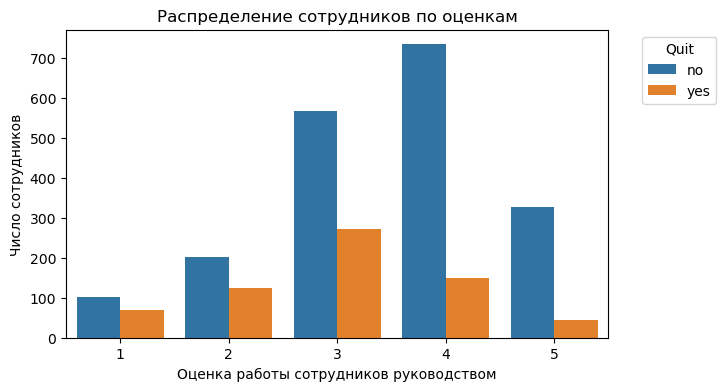

In [137]:
plt.figure(figsize=(7, 4))
sns.countplot(x = 'supervisor_evaluation', hue = 'quit', data = train_quit)
plt.xlabel('Оценка работы сотрудников руководством')
plt.ylabel('Число сотрудников')
plt.title('Распределение сотрудников по оценкам')
plt.legend(title='Quit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Построим гистограмму распределения признака доли увольняющихся и остающихся сотрудников, имеющие разные оценки качества работы.

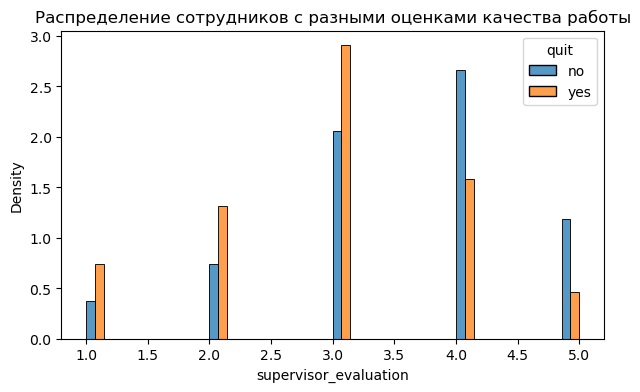

In [139]:
plt.figure(figsize=(7, 4))
sns.histplot(data=train_quit, 
             x="supervisor_evaluation",  
             hue="quit", 
             multiple="dodge",
             shrink = 1,
             stat='density', 
             common_norm=False).set(title='Распределение сотрудников с разными оценками качества работы');

Больше всего в абсолютном выражении увольняются сотрудники, получившие среднюю оценку за работу. В относительном выражении больше всего увольняются сотрудники, получишие минимальную оценку (47%) и плохую оценку (42%).

Опишем ***портрет уволившегося сотрудника***:

Среднестатистический уволившийся сотрудник имеет зарплату 23 тыс.руб., работает в компании 1 год (реже 2), работал в отделе продаж или технологий, имел низкий уровень загрузки, не получал повышений за последний маесяц, каждый 2ой-3-й уволившийся сотрудник допускал нарушения трудового договора и среднюю оценку начальства за качества работы.

Для того чтобы сравнить распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников объединим табоицы satisf_test_target и test_target_quit.
Перед объединением убедимся. что строки в обеих таблицах расположены в одном порядке, посмотрим на порядок id:

In [140]:
display(test_target_quit.head())

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


In [141]:
display(satisf_test_target.head())

,job_satisfaction_rate
id,
100298,0.80
100480,0.84
100503,0.79
100610,0.75
100692,0.69


Строки расположены в одинаковом порядке, объединяем таблицы.

In [142]:
target_both = pd.merge(satisf_test_target, test_target_quit, on = 'id', how = 'outer')
display(target_both.tail())

,job_satisfaction_rate,quit
id,,
997290,0.79,no
998548,0.76,yes
998762,0.48,yes
998900,0.57,no
999029,0.35,yes


Для сравнения распределения признака job_satisfaction_rate у ушедших и оставшихся сотрудников разделим получившуюся таблицу

In [143]:
#список значений признака  job_satisfaction_rate оставшихся сотрудников
x1 = list(target_both[target_both['quit'] == 'no']['job_satisfaction_rate'])

#список значений признака  job_satisfaction_rate уволившихся сотрудников
x2 = list(target_both[target_both['quit'] == 'yes']['job_satisfaction_rate'])


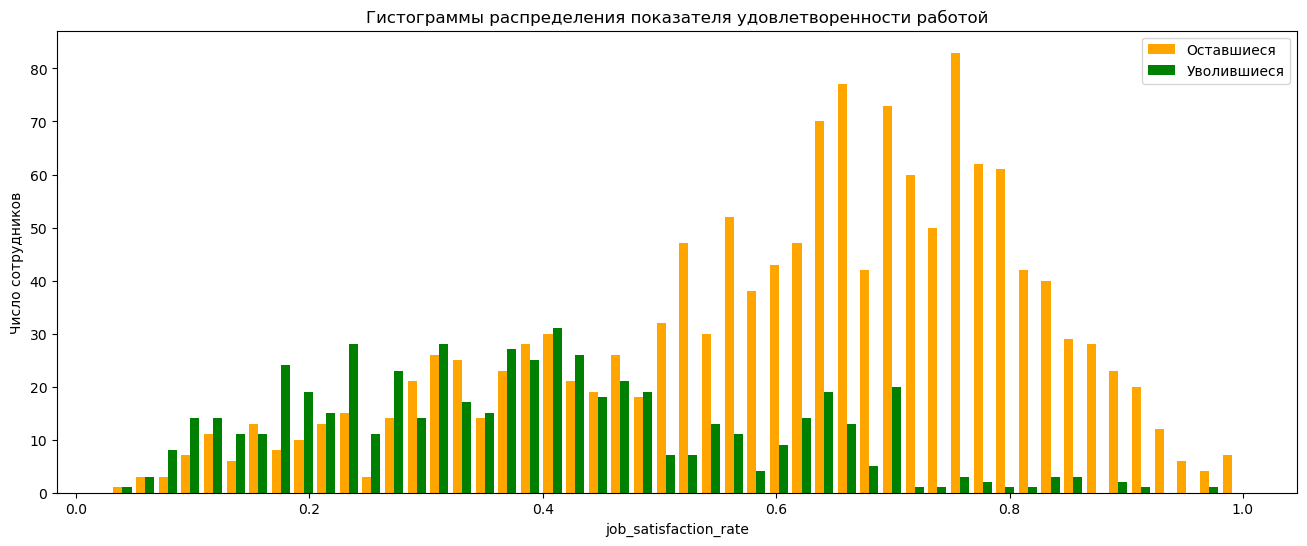

In [145]:
colors = ['orange', 'green']
names = ['Оставшиеся', 'Уволившиеся']

k = plt.figure()
k.set_figwidth(16)
k.set_figheight(6)
plt.hist([x1, x2], bins = 50,
         color = colors, label=names)

plt.legend()
plt.title('Гистограммы распределения показателя удовлетворенности работой')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Число сотрудников')
plt.show();

Построим гистограмму уровня удовлетворенности работой ушедших и оставшихся сотрудников.

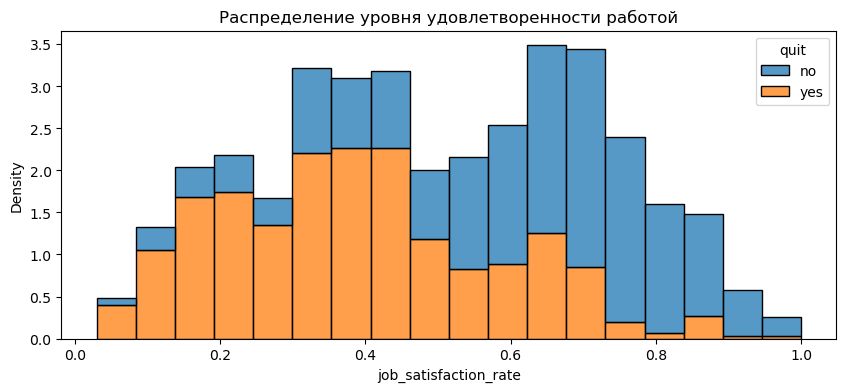

In [147]:
plt.figure(figsize=(10, 4))
sns.histplot(data=target_both, 
             x="job_satisfaction_rate",  
             hue="quit", 
             multiple="stack",
             stat='density', 
             common_norm=False).set(title='Распределение уровня удовлетворенности работой');

Построим диаграммы размаха уровня удовлетворенности работой оставшихся и уволившихся сотрудников. Для этого разделим таблицу на оставшихся и уволившихся.

In [148]:
stable = target_both[target_both['quit'] == 'no']
retired = target_both[target_both['quit'] == 'yes']

In [149]:
display(stable.head())

,job_satisfaction_rate,quit
id,,
100298,0.80,no
100480,0.84,no
100503,0.79,no
100610,0.75,no
100692,0.69,no


Статистика: count    1436.000000
mean        0.612040
std         0.199367
min         0.030000
25%         0.500000
50%         0.660000
75%         0.760000
max         1.000000
Name: job_satisfaction_rate, dtype: float64


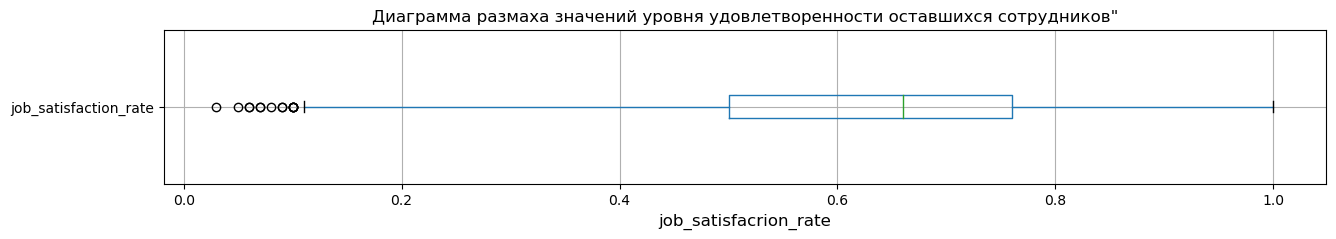

In [150]:
fig, ax = plt.subplots(figsize = (15,2))
ax = stable[['job_satisfaction_rate']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений уровня удовлетворенности оставшихся сотрудников"')
ax.set_xlabel('job_satisfacrion_rate', fontsize = 12)

;

print('Статистика:', stable['job_satisfaction_rate'].describe())

Статистика: count    564.000000
mean       0.387713
std        0.185784
min        0.040000
25%        0.240000
50%        0.370000
75%        0.492500
max        0.970000
Name: job_satisfaction_rate, dtype: float64


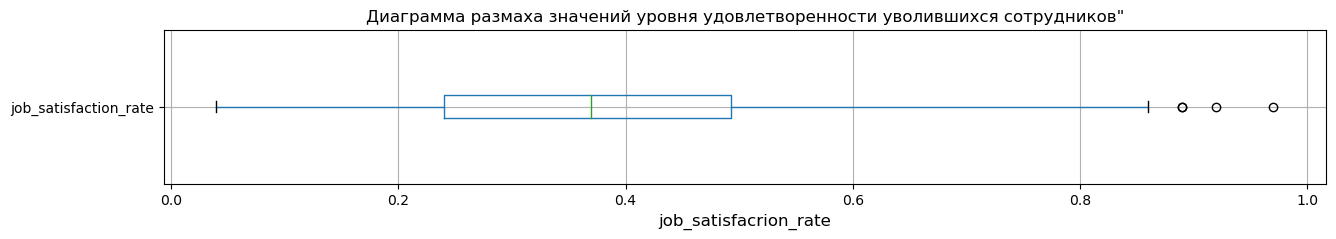

In [151]:
fig, ax = plt.subplots(figsize = (15,2))
ax = retired[['job_satisfaction_rate']].boxplot(vert = False, ax =ax)
ax.set_title('Диаграмма размаха значений уровня удовлетворенности уволившихся сотрудников"')
ax.set_xlabel('job_satisfacrion_rate', fontsize = 12)

;

print('Статистика:', retired['job_satisfaction_rate'].describe())

На гистограммах и диаграммах рахмаха отчетливо видна корреляция между вровнем удовлетворенности и вероятностью увольнения сотрудников: средний job_satisfaction_rate оставшихся сотрудников равен 66%, 3/4 сотрудников имеют job_satisfaction_rate не ниже 76%.
В то время как средний job_satisfaction_rate уволившихся сотрудников равен 37%, 3/4 сотрудников имеют job_satisfaction_rate не ниже 49%.

**Шаг 4. Добавление нового входного признака**

Чтобы добавить job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи, сделаем следующее:

В тренировочную выборку train_quit добавим прогноз job_satisfaction_rate, полученный с помощью лучшей модели первой задачи, рассчитанный на данных из train_quit. 

Для этого подготовим данные train_quit для прогноза.

In [152]:
display(train_quit.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


Уберем признак quit, т к его не было во входных признаках модели из перой задачи.


In [153]:
train_quit_correct = train_quit.drop(['quit'], axis=1)
display(train_quit_correct.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000
814010,sales,junior,medium,2,no,no,4,27600
155091,purchasing,middle,medium,5,no,no,1,37200
257132,sales,junior,medium,2,no,yes,3,24000
910140,marketing,junior,medium,2,no,no,5,25200


Сделаем предсказания признака job_satisfaction_rate на данных train_quit с помощью лучшей модели из первой задачи.

In [154]:
job_satisf_pred = randomized_search.predict(train_quit_correct)


In [155]:
train_quit_correct['job_satisf_rate_pred'] = job_satisf_pred
train_quit_new = train_quit_correct
display(train_quit_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.635385
814010,sales,junior,medium,2,no,no,4,27600,0.843158
155091,purchasing,middle,medium,5,no,no,1,37200,0.326667
257132,sales,junior,medium,2,no,yes,3,24000,0.333333
910140,marketing,junior,medium,2,no,no,5,25200,0.845000


Добавим признак job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам тестовой выборки второй задачи. Подготовим данные satisf_test_features для прогноза.

In [156]:
display(satisf_test_features.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200
100480,marketing,junior,low,4,no,no,4,16800
100503,purchasing,middle,high,5,no,no,4,55200
100610,sales,middle,medium,5,no,no,4,43200
100692,sales,middle,high,6,no,no,4,48000


Сделаем предсказания признака job_satisfaction_rate на данных satisf_test_features с помощью лучшей модели из первой задачи.

In [157]:
job_satisf_pred_test = randomized_search.predict(satisf_test_features)

C:\Users\babay\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [158]:
satisf_test_features['job_satisf_rate_pred'] = job_satisf_pred_test
satisf_test_features_new = satisf_test_features
display(satisf_test_features_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.852500
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.791765
100610,sales,middle,medium,5,no,no,4,43200,0.835000
100692,sales,middle,high,6,no,no,4,48000,0.679565


В тренировочную выборку train_quit добавили прогноз job_satisfaction_rate, полученный с помощью лучшей модели первой задачи, рассчитанный на данных из train_quit.

**Шаг 5. Подготовка данных**

Проверим порядок строк в файлах satisf_test_features и test_target_quit:

In [159]:
display(satisf_test_features_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.852500
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.791765
100610,sales,middle,medium,5,no,no,4,43200,0.835000
100692,sales,middle,high,6,no,no,4,48000,0.679565


In [160]:
display(test_target_quit.head())

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


Строки в тестовой выборке входных признаков и тестовой выборке целевого признака расположены в одинаковом порядке, id совпадают.

Перед подготовкой данных переместим id в индексы:

In [161]:
#тренировочная выборка:
#train_quit_new = train_quit_new.set_index('id')
display(train_quit_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.635385
814010,sales,junior,medium,2,no,no,4,27600,0.843158
155091,purchasing,middle,medium,5,no,no,1,37200,0.326667
257132,sales,junior,medium,2,no,yes,3,24000,0.333333
910140,marketing,junior,medium,2,no,no,5,25200,0.845000


In [162]:
#тестовая выборка, входные признаки:
#satisf_test_features_new = satisf_test_features_new.set_index('id')
display(satisf_test_features_new.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.852500
100480,marketing,junior,low,4,no,no,4,16800,0.841667
100503,purchasing,middle,high,5,no,no,4,55200,0.791765
100610,sales,middle,medium,5,no,no,4,43200,0.835000
100692,sales,middle,high,6,no,no,4,48000,0.679565


In [163]:
#тестовая выборка, целевой признак:
#test_target_quit = test_target_quit.set_index('id')
display(test_target_quit.head())

,quit
id,
100298,no
100480,no
100503,no
100610,no
100692,no


РАзделим тренировочную выборку второй задачи на входные и целевой признаки:

In [164]:
X_train_ = train_quit_new
y_train_ = train_quit['quit']

X_test_ = satisf_test_features_new
y_test_ = test_target_quit['quit']

Закодируем целевой признак с помощью LabelEncoder

In [165]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train_)

y_train_ = label_encoder.transform(y_train_)
y_test_ = label_encoder.transform(y_test_) 

Определим перечни столбцов с категориальными и количественными признаками:

In [166]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

ord_columns = ['level', 'workload', 'supervisor_evaluation']

num_columns = ['employment_years', 'salary', 'job_satisf_rate_pred']

Добавляем ***OHE-кодирование*** в Пайплайн

***1)*** Если в данных есть пропуски, заполним их самым часто встречающимся значением с помощью SimpleImputer. Назовём этот шаг simpleImputer_ohe.

***2)*** Кодируем данные с помощью OneHotEncoder. Назовём это шаг ohe.

***3)*** Объединим шаги в пайплайн и назовём его ohe_pipe.

In [167]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

Добавляем **Ordinal-кодирование** в пайплайн.

**1)** simpleImputer_before_ord: Заполним пропуски самым часто встречающимся значением с помощью SimpleImputer. Пропуски есть только в столбце 'level': по уровню зарплаты (ниже среднего) в этих строках с пропусками можно сделать вывод, что эти сотрудники имеют должность junior, которая как раз является самым распространенным значением признака, поэтому в данном случае заполнение most_frequent будет корректно.

**2)** ord: Проводим Ordinal-кодирование с помощью OrdinalEncoder.

**3)** simpleImputer_after_ord: Заполним пропуски, которые появляются после Ordinal-кодирования.

**4)** ord_pipe: Объединим все действия в пайплайн.

In [168]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'sinior'],
                             ['low', 'medium', 'high'],
                             [1, 2, 3, 4, 5]
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

Применим ColumnTRansformer для объединения шагов по подготовке данных.

In [169]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Пайплайн подготовки данных готов. Переходим к обучению модели.

Будем использовать модель DecisionTreeClassifier. Итоговый пайплайн назовём pipe_final. Он включает шаги:

Подготовка данных — шаг preprocessor. Инициализация модели DecisionTreeClassifier — шаг models.

In [170]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Зададим метод масштабирования как гиперпараметр, чтобы перебирались методы StandardScaler(), RobustScaler() и MinMaxScaler(). Для автоматического подбора гиперпараметров будем использовать инструмент RandomizedSearchCV.

В словаре укажем, какие варианты масштабирования собираемся перебрать: StandardScaler(), RobustScaler(), MinMaxScaler() и вариант без масштабирования.

Зададим в качестве гиперпараметра модели, которые хотим использовать: DecisionTreeRegressor(), KNeighborsClassifier(), LogisticRegression().

In [171]:
param_rs = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 8), 
        'models__max_features': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']
    },
   
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression
        (
         random_state=RANDOM_STATE, 
            solver='liblinear',
            class_weight='balanced',
            penalty='l1'
        )
                  ],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    }
]

В качестве метрики качества работы модели будем использовать roc_auc.
Запустим автоматический подбор с помощью RandomizedSearchCV:

In [172]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_rs, 
    scoring = 'roc_auc',
    cv=5,
    n_iter=20,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search_2.fit(X_train_, y_train_) 

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpl...
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [173]:
print('Метрика ROC_AUC для лучшей модели:\n', randomized_search_2.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_) 

Метрика ROC_AUC для лучшей модели:
 0.9009051132906762
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleI

Лучшая модель по итогам отбора - KNeighborsClassifier, модель показала высокую метрику roc_auc 90,4%.
Проверим результат работы лучше модели на тестовой выборке:

In [174]:
y_test_pred_ = randomized_search_2.predict_proba(X_test_)
#отбор 2 столбца, с вероятностью принадлежности к классу 1
y_test_pred_one = y_test_pred_[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test_, y_test_pred_one))

Метрика ROC-AUC на тестовой выборке: 0.9094059295916553


C:\Users\babay\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика на тестовой выборrе еще лучше - 90,9%. Можем считать, что добились нужного результата.

In [176]:
best_model_2 = randomized_search_2.best_estimator_

In [177]:
ohe_columns_2 = best_model_2.named_steps['preprocessor'].named_transformers_['ohe'].get_feature_names_out()
ord_columns_2 = best_model_2.named_steps['preprocessor'].named_transformers_['ord'].get_feature_names_out()
num_columns_2 = best_model_2.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out()

In [178]:
X_train_transformed_2 = best_model_2.named_steps['preprocessor'].fit_transform(X_train_)
X_test_transformed_2 = best_model_2.named_steps['preprocessor'].transform(X_test_)

C:\Users\babay\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [179]:
columns_2 = np.concatenate((ohe_columns_2, ord_columns_2, num_columns_2), axis =0)

In [180]:
# переводим подготовленные выборки в датафреймы:
X_train_transformed_2 = pd.DataFrame(X_train_transformed_2, columns = columns_2 )
X_test_transformed_2 = pd.DataFrame(X_test_transformed_2, columns = columns_2 )

In [181]:
X_train_transformed_2.shape, best_model_2

((2587, 12),
 Pipeline(steps=[('preprocessor',
                  ColumnTransformer(remainder='passthrough',
                                    transformers=[('ohe',
                                                   Pipeline(steps=[('simpleImputer_ohe',
                                                                    SimpleImputer(strategy='most_frequent')),
                                                                   ('ohe',
                                                                    OneHotEncoder(drop='first',
                                                                                  handle_unknown='ignore'))]),
                                                   ['dept', 'last_year_promo',
                                                    'last_year_violations']),
                                                  ('ord',
                                                   Pipeline(steps=[('simpleImputer_before_ord',
                                          

  0%|          | 0/50 [00:00<?, ?it/s]

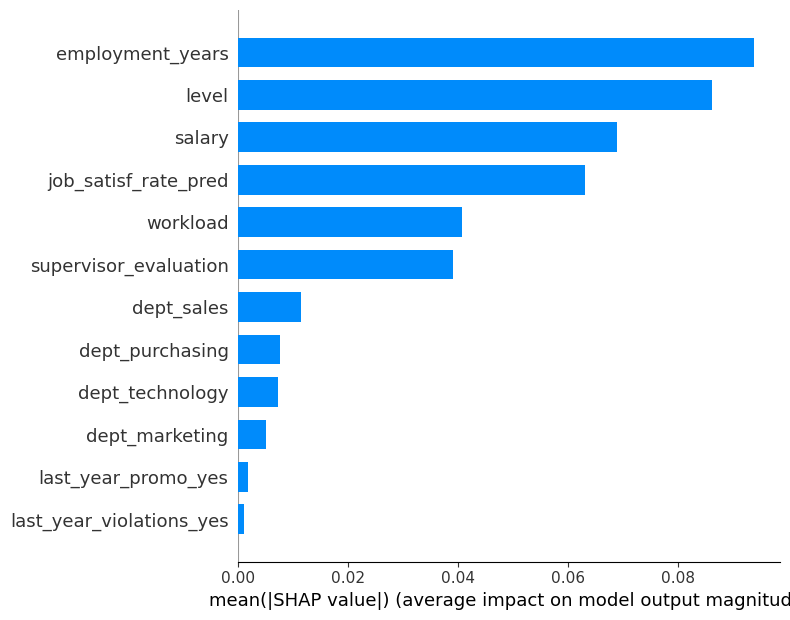

In [182]:
explainer = shap.KernelExplainer(randomized_search_2.best_estimator_['models'].predict_proba,\
                                 shap.sample(X_test_transformed_2, 50, random_state=RANDOM_STATE))

shap_values = explainer(shap.sample(X_test_transformed_2, 50, random_state=RANDOM_STATE))

shap.summary_plot(shap_values[:,:,1], plot_type='bar', max_display=15)

Уберем dept из категориальных признаков:

In [183]:
X_train_3 = X_train_.drop(['dept'], axis= 1)
X_test_3 = X_test_.drop(['dept'], axis= 1)


In [184]:
X_train_.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,0.635385
814010,sales,junior,medium,2,no,no,4,27600,0.843158
155091,purchasing,middle,medium,5,no,no,1,37200,0.326667
257132,sales,junior,medium,2,no,yes,3,24000,0.333333
910140,marketing,junior,medium,2,no,no,5,25200,0.845000


In [185]:
X_train_3.head()

,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisf_rate_pred
id,,,,,,,,
723290,middle,high,2,no,no,4,54000,0.635385
814010,junior,medium,2,no,no,4,27600,0.843158
155091,middle,medium,5,no,no,1,37200,0.326667
257132,junior,medium,2,no,yes,3,24000,0.333333
910140,junior,medium,2,no,no,5,25200,0.845000


In [186]:
ohe_columns_3 = ['last_year_promo', 'last_year_violations']

ord_columns_3 = ['level', 'workload', 'supervisor_evaluation']

num_columns_3 = ['employment_years', 'salary', 'job_satisf_rate_pred']

In [187]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore')
        )
    ]
) 

In [188]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories = [
                             ['junior', 'middle', 'sinior'],
                             ['low', 'medium', 'high'],
                             [1, 2, 3, 4, 5]
                            ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [189]:
data_preprocessor_3 = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns_3),
        ('ord', ord_pipe, ord_columns_3),
        ('num', StandardScaler(), num_columns_3)
    ], 
    remainder='passthrough'
) 

In [190]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor_3),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
) 

Увеличим число итераций до 50.

In [191]:
randomized_search_3 = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_rs, 
    scoring = 'roc_auc',
    cv=5,
    n_iter=50,
    random_state=RANDOM_STATE, 
    n_jobs=-1
)
randomized_search_3.fit(X_train_3, y_train_) 

C:\Users\babay\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore'))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImpute...
                                         'models__n_neighbors': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(class_weight='balanced',
                                                                       penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [192]:
print('Метрика ROC_AUC для лучшей модели:\n', randomized_search_3.best_score_)
print('Лучшая модель и её параметры:\n\n', randomized_search_3.best_estimator_) 

Метрика ROC_AUC для лучшей модели:
 0.9100704367643548
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_b

Сделаем прогноз на данных на тестовой выборке и посчитаем метрику ROC_AUC на данных тестовой выборки:

In [193]:
y_test_pred_3 = randomized_search_3.predict_proba(X_test_3)
#отбор 2 столбца, с вероятностью принадлежности к классу 1
y_test_pred_proba = y_test_pred_3[:, 1]
print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test_, y_test_pred_proba))

Метрика ROC-AUC на тестовой выборке: 0.9159264554811435


**Вывод:** 

Лучшей моделью по итогам подбора RandomizedSearchCV стала модель ближайших соседей с параметром n_neighbors = 19. Нам удалось улучшить качество модели удалением незначимого признака 'dept' и увеличения числа итераций естиматора RandomizedSearch до 50. В результате мы улучшили метрику roc_auc модели на тестовой выборке до 91,6%.

**Общий вывод:**

Перед нами стояла задача  помочь HR-аналитикам компании «Работа с заботой» оптимизировать управление персоналом, для реализации которой мы выполнили две задачи:

***1)*** Построили модель, предсказывающую уровень удовлетворённости работой сотрудников на основе данных заказчика.

***2)*** Предсказать отток сотрудников, построив модель, прогнозирующую увольнение сотрудников из компании.

***Для решения первой задачи*** мы обучили 2 модели: дерево решений и линейную регрессию, в качестве гипарпараметров использовали методы масштабирования, Для автоматического подбора гиперпараметров использовали инструмент RandomizedSearchCV.

Для оценки работы модели мы создали метрику SMAPE («симметричное среднее абсолютное процентное отклонение») По итогам подбора лучшей моделью стала модель DecisionTreeRegressor со следующими параметрами: criterion='friedman_mse', max_depth=11, max_features=10, min_samples_leaf=4, min_samples_split=14. Метрика SMAPE на тестовой выборке - 14,09%.

***Для решения второй задачи*** мы обучили 3 модели: дерево решений, метод ближайших соседей и логистическую регрессию. На первом этапе получили достаточно выоскую метрику roc_auc на тестовой выборке (90,9%). Далее мы убрали незначимый признак 'dept', увеличили число итераций эстиматора RandomizedSearch, по итогам получили лучшую модель KNeighborClassifier  с параметром n_neighbors = 19 и еще более высокой метрикой roc_auc на тестовой выборке 91,6%.

***Предложение для бизнеса:***
По итогам исследовательского анализа данных мы увидели крайне низкий процент повышений (3% сотрудников) за последний год, высокую долю сотрудников начального уровня с низкими зарплатами и высокую текучку кадров этой категории сотрудников. 
В качестве увеличения мотивации и уровня удовлетворенности работой в компании можно предложить выстроить систему, позволяющую  обучать сотрудников, стимулировать карьерный рост, увеличивать зону ответственности и зарплаты сотрудников уровня junior, обеспечить больше перспектив для повышения уровня занимаемой должности. 